In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_025_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1234135, 828)
(1234135, 8)
validation
(145146, 828)
(145146, 8)
test
(178765, 828)
(178765, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/124 [..............................] - ETA: 3:21 - loss: 2.0274 - STD: 0.0839 - MAE: 0.2088

  4/124 [..............................] - ETA: 2s - loss: 1.9682 - STD: 0.0818 - MAE: 0.2069  

  7/124 [>.............................] - ETA: 2s - loss: 1.9600 - STD: 0.0841 - MAE: 0.2061

 10/124 [=>............................] - ETA: 2s - loss: 1.9528 - STD: 0.0823 - MAE: 0.2062

 13/124 [==>...........................] - ETA: 2s - loss: 1.9454 - STD: 0.0810 - MAE: 0.2061

 16/124 [==>...........................] - ETA: 2s - loss: 1.9395 - STD: 0.0819 - MAE: 0.2057

 19/124 [===>..........................] - ETA: 2s - loss: 1.9316 - STD: 0.0808 - MAE: 0.2055

 22/124 [====>.........................] - ETA: 2s - loss: 1.9222 - STD: 0.0825 - MAE: 0.2048

 25/124 [=====>........................] - ETA: 2s - loss: 1.9135 - STD: 0.0842 - MAE: 0.2041

 28/124 [=====>........................] - ETA: 2s - loss: 1.9047 - STD: 0.0867 - MAE: 0.2032

 31/124 [======>.......................] - ETA: 2s - loss: 1.8950 - STD: 0.0884 - MAE: 0.2025

 34/124 [=======>......................] - ETA: 2s - loss: 1.8853 - STD: 0.0898 - MAE: 0.2018

 37/124 [=======>......................] - ETA: 1s - loss: 1.8753 - STD: 0.0908 - MAE: 0.2013

 40/124 [========>.....................] - ETA: 1s - loss: 1.8638 - STD: 0.0921 - MAE: 0.2006

 43/124 [=========>....................] - ETA: 1s - loss: 1.8513 - STD: 0.0935 - MAE: 0.1999

 46/124 [==========>...................] - ETA: 1s - loss: 1.8380 - STD: 0.0949 - MAE: 0.1992

 49/124 [==========>...................] - ETA: 1s - loss: 1.8241 - STD: 0.0965 - MAE: 0.1984

 52/124 [===========>..................] - ETA: 1s - loss: 1.8103 - STD: 0.0980 - MAE: 0.1976

 55/124 [============>.................] - ETA: 1s - loss: 1.7958 - STD: 0.0998 - MAE: 0.1967

 58/124 [=============>................] - ETA: 1s - loss: 1.7813 - STD: 0.1014 - MAE: 0.1959

 61/124 [=============>................] - ETA: 1s - loss: 1.7670 - STD: 0.1030 - MAE: 0.1950

 64/124 [==============>...............] - ETA: 1s - loss: 1.7526 - STD: 0.1046 - MAE: 0.1942

 67/124 [===============>..............] - ETA: 1s - loss: 1.7384 - STD: 0.1061 - MAE: 0.1933

 70/124 [===============>..............] - ETA: 1s - loss: 1.7240 - STD: 0.1079 - MAE: 0.1924

 73/124 [================>.............] - ETA: 1s - loss: 1.7101 - STD: 0.1095 - MAE: 0.1916

 76/124 [=================>............] - ETA: 1s - loss: 1.6964 - STD: 0.1111 - MAE: 0.1907

 79/124 [==================>...........] - ETA: 1s - loss: 1.6839 - STD: 0.1128 - MAE: 0.1898

 81/124 [==================>...........] - ETA: 1s - loss: 1.6780 - STD: 0.1138 - MAE: 0.1893

 84/124 [===================>..........] - ETA: 1s - loss: 1.6665 - STD: 0.1153 - MAE: 0.1885

 87/124 [====================>.........] - ETA: 1s - loss: 1.6552 - STD: 0.1169 - MAE: 0.1877

 90/124 [====================>.........] - ETA: 1s - loss: 1.6445 - STD: 0.1182 - MAE: 0.1870

 93/124 [=====================>........] - ETA: 0s - loss: 1.6341 - STD: 0.1196 - MAE: 0.1863

 96/124 [======================>.......] - ETA: 0s - loss: 1.6243 - STD: 0.1209 - MAE: 0.1856

 99/124 [======================>.......] - ETA: 0s - loss: 1.6150 - STD: 0.1222 - MAE: 0.1849

102/124 [=======================>......] - ETA: 0s - loss: 1.6056 - STD: 0.1234 - MAE: 0.1843

105/124 [========================>.....] - ETA: 0s - loss: 1.5969 - STD: 0.1246 - MAE: 0.1837

108/124 [=========================>....] - ETA: 0s - loss: 1.5883 - STD: 0.1257 - MAE: 0.1831

111/124 [=========================>....] - ETA: 0s - loss: 1.5803 - STD: 0.1268 - MAE: 0.1825

114/124 [==========================>...] - ETA: 0s - loss: 1.5726 - STD: 0.1279 - MAE: 0.1819

117/124 [===========================>..] - ETA: 0s - loss: 1.5650 - STD: 0.1289 - MAE: 0.1813

120/124 [============================>.] - ETA: 0s - loss: 1.5576 - STD: 0.1299 - MAE: 0.1808

123/124 [============================>.] - ETA: 0s - loss: 1.5502 - STD: 0.1309 - MAE: 0.1802

124/124 [==============================] - 6s 37ms/step - loss: 1.5478 - STD: 0.1312 - MAE: 0.1801 - val_loss: 1.2870 - val_STD: 0.1693 - val_MAE: 0.1591


Epoch 2/10000


  1/124 [..............................] - ETA: 5s - loss: 1.2707 - STD: 0.1694 - MAE: 0.1592

  4/124 [..............................] - ETA: 2s - loss: 1.2627 - STD: 0.1709 - MAE: 0.1582

  7/124 [>.............................] - ETA: 2s - loss: 1.2582 - STD: 0.1721 - MAE: 0.1576

 10/124 [=>............................] - ETA: 2s - loss: 1.2574 - STD: 0.1729 - MAE: 0.1573

 13/124 [==>...........................] - ETA: 2s - loss: 1.2534 - STD: 0.1734 - MAE: 0.1569

 16/124 [==>...........................] - ETA: 2s - loss: 1.2512 - STD: 0.1738 - MAE: 0.1567

 19/124 [===>..........................] - ETA: 2s - loss: 1.2496 - STD: 0.1740 - MAE: 0.1565

 22/124 [====>.........................] - ETA: 2s - loss: 1.2485 - STD: 0.1744 - MAE: 0.1564

 25/124 [=====>........................] - ETA: 2s - loss: 1.2483 - STD: 0.1748 - MAE: 0.1563

 28/124 [=====>........................] - ETA: 2s - loss: 1.2465 - STD: 0.1749 - MAE: 0.1561

 31/124 [======>.......................] - ETA: 2s - loss: 1.2451 - STD: 0.1751 - MAE: 0.1560

 34/124 [=======>......................] - ETA: 2s - loss: 1.2433 - STD: 0.1752 - MAE: 0.1559

 37/124 [=======>......................] - ETA: 1s - loss: 1.2415 - STD: 0.1755 - MAE: 0.1557

 40/124 [========>.....................] - ETA: 1s - loss: 1.2399 - STD: 0.1755 - MAE: 0.1556

 43/124 [=========>....................] - ETA: 1s - loss: 1.2388 - STD: 0.1757 - MAE: 0.1555

 46/124 [==========>...................] - ETA: 1s - loss: 1.2372 - STD: 0.1760 - MAE: 0.1553

 49/124 [==========>...................] - ETA: 1s - loss: 1.2363 - STD: 0.1763 - MAE: 0.1552

 52/124 [===========>..................] - ETA: 1s - loss: 1.2353 - STD: 0.1765 - MAE: 0.1551

 55/124 [============>.................] - ETA: 1s - loss: 1.2341 - STD: 0.1766 - MAE: 0.1550

 58/124 [=============>................] - ETA: 1s - loss: 1.2326 - STD: 0.1767 - MAE: 0.1549

 61/124 [=============>................] - ETA: 1s - loss: 1.2314 - STD: 0.1769 - MAE: 0.1547

 64/124 [==============>...............] - ETA: 1s - loss: 1.2298 - STD: 0.1771 - MAE: 0.1546

 67/124 [===============>..............] - ETA: 1s - loss: 1.2286 - STD: 0.1772 - MAE: 0.1545

 70/124 [===============>..............] - ETA: 1s - loss: 1.2281 - STD: 0.1774 - MAE: 0.1544

 73/124 [================>.............] - ETA: 1s - loss: 1.2273 - STD: 0.1775 - MAE: 0.1543

 76/124 [=================>............] - ETA: 1s - loss: 1.2267 - STD: 0.1777 - MAE: 0.1543

 79/124 [==================>...........] - ETA: 1s - loss: 1.2259 - STD: 0.1779 - MAE: 0.1542

 82/124 [==================>...........] - ETA: 0s - loss: 1.2246 - STD: 0.1781 - MAE: 0.1540

 85/124 [===================>..........] - ETA: 0s - loss: 1.2233 - STD: 0.1783 - MAE: 0.1539

 88/124 [====================>.........] - ETA: 0s - loss: 1.2220 - STD: 0.1784 - MAE: 0.1538

 91/124 [=====================>........] - ETA: 0s - loss: 1.2210 - STD: 0.1785 - MAE: 0.1537

 94/124 [=====================>........] - ETA: 0s - loss: 1.2201 - STD: 0.1786 - MAE: 0.1536

 97/124 [======================>.......] - ETA: 0s - loss: 1.2191 - STD: 0.1788 - MAE: 0.1535

100/124 [=======================>......] - ETA: 0s - loss: 1.2183 - STD: 0.1789 - MAE: 0.1534

103/124 [=======================>......] - ETA: 0s - loss: 1.2173 - STD: 0.1791 - MAE: 0.1533

106/124 [========================>.....] - ETA: 0s - loss: 1.2162 - STD: 0.1793 - MAE: 0.1532

109/124 [=========================>....] - ETA: 0s - loss: 1.2152 - STD: 0.1794 - MAE: 0.1531

112/124 [==========================>...] - ETA: 0s - loss: 1.2143 - STD: 0.1795 - MAE: 0.1530

115/124 [==========================>...] - ETA: 0s - loss: 1.2131 - STD: 0.1796 - MAE: 0.1529

118/124 [===========================>..] - ETA: 0s - loss: 1.2119 - STD: 0.1798 - MAE: 0.1528

121/124 [============================>.] - ETA: 0s - loss: 1.2108 - STD: 0.1800 - MAE: 0.1527

124/124 [==============================] - ETA: 0s - loss: 1.2098 - STD: 0.1801 - MAE: 0.1526

124/124 [==============================] - 3s 25ms/step - loss: 1.2098 - STD: 0.1801 - MAE: 0.1526 - val_loss: 1.2390 - val_STD: 0.1827 - val_MAE: 0.1500


Epoch 3/10000


  1/124 [..............................] - ETA: 6s - loss: 1.1779 - STD: 0.1865 - MAE: 0.1488

  4/124 [..............................] - ETA: 2s - loss: 1.1759 - STD: 0.1848 - MAE: 0.1492

  7/124 [>.............................] - ETA: 2s - loss: 1.1754 - STD: 0.1853 - MAE: 0.1492

 10/124 [=>............................] - ETA: 2s - loss: 1.1711 - STD: 0.1859 - MAE: 0.1487

 13/124 [==>...........................] - ETA: 2s - loss: 1.1684 - STD: 0.1860 - MAE: 0.1486

 16/124 [==>...........................] - ETA: 2s - loss: 1.1667 - STD: 0.1862 - MAE: 0.1485

 19/124 [===>..........................] - ETA: 2s - loss: 1.1634 - STD: 0.1866 - MAE: 0.1481

 22/124 [====>.........................] - ETA: 2s - loss: 1.1617 - STD: 0.1868 - MAE: 0.1480

 25/124 [=====>........................] - ETA: 2s - loss: 1.1607 - STD: 0.1869 - MAE: 0.1479

 28/124 [=====>........................] - ETA: 2s - loss: 1.1594 - STD: 0.1870 - MAE: 0.1478

 31/124 [======>.......................] - ETA: 2s - loss: 1.1592 - STD: 0.1869 - MAE: 0.1478

 34/124 [=======>......................] - ETA: 2s - loss: 1.1573 - STD: 0.1871 - MAE: 0.1477

 37/124 [=======>......................] - ETA: 1s - loss: 1.1572 - STD: 0.1873 - MAE: 0.1476

 40/124 [========>.....................] - ETA: 1s - loss: 1.1559 - STD: 0.1873 - MAE: 0.1475

 43/124 [=========>....................] - ETA: 1s - loss: 1.1548 - STD: 0.1875 - MAE: 0.1474

 46/124 [==========>...................] - ETA: 1s - loss: 1.1538 - STD: 0.1876 - MAE: 0.1473

 49/124 [==========>...................] - ETA: 1s - loss: 1.1533 - STD: 0.1877 - MAE: 0.1472

 52/124 [===========>..................] - ETA: 1s - loss: 1.1527 - STD: 0.1877 - MAE: 0.1472

 55/124 [============>.................] - ETA: 1s - loss: 1.1519 - STD: 0.1879 - MAE: 0.1471

 58/124 [=============>................] - ETA: 1s - loss: 1.1515 - STD: 0.1881 - MAE: 0.1470

 61/124 [=============>................] - ETA: 1s - loss: 1.1511 - STD: 0.1882 - MAE: 0.1470

 64/124 [==============>...............] - ETA: 1s - loss: 1.1518 - STD: 0.1881 - MAE: 0.1470

 67/124 [===============>..............] - ETA: 1s - loss: 1.1522 - STD: 0.1882 - MAE: 0.1470

 70/124 [===============>..............] - ETA: 1s - loss: 1.1524 - STD: 0.1883 - MAE: 0.1470

 73/124 [================>.............] - ETA: 1s - loss: 1.1516 - STD: 0.1884 - MAE: 0.1469

 76/124 [=================>............] - ETA: 1s - loss: 1.1516 - STD: 0.1884 - MAE: 0.1469

 79/124 [==================>...........] - ETA: 1s - loss: 1.1510 - STD: 0.1884 - MAE: 0.1469

 82/124 [==================>...........] - ETA: 0s - loss: 1.1501 - STD: 0.1885 - MAE: 0.1468

 85/124 [===================>..........] - ETA: 0s - loss: 1.1492 - STD: 0.1886 - MAE: 0.1467

 88/124 [====================>.........] - ETA: 0s - loss: 1.1484 - STD: 0.1887 - MAE: 0.1467

 91/124 [=====================>........] - ETA: 0s - loss: 1.1475 - STD: 0.1888 - MAE: 0.1466

 94/124 [=====================>........] - ETA: 0s - loss: 1.1469 - STD: 0.1889 - MAE: 0.1465

 97/124 [======================>.......] - ETA: 0s - loss: 1.1457 - STD: 0.1889 - MAE: 0.1465

100/124 [=======================>......] - ETA: 0s - loss: 1.1448 - STD: 0.1890 - MAE: 0.1464

103/124 [=======================>......] - ETA: 0s - loss: 1.1443 - STD: 0.1891 - MAE: 0.1463

106/124 [========================>.....] - ETA: 0s - loss: 1.1435 - STD: 0.1892 - MAE: 0.1462

109/124 [=========================>....] - ETA: 0s - loss: 1.1428 - STD: 0.1893 - MAE: 0.1462

112/124 [==========================>...] - ETA: 0s - loss: 1.1422 - STD: 0.1894 - MAE: 0.1461

115/124 [==========================>...] - ETA: 0s - loss: 1.1416 - STD: 0.1895 - MAE: 0.1460

118/124 [===========================>..] - ETA: 0s - loss: 1.1409 - STD: 0.1896 - MAE: 0.1460

121/124 [============================>.] - ETA: 0s - loss: 1.1403 - STD: 0.1896 - MAE: 0.1459

124/124 [==============================] - ETA: 0s - loss: 1.1396 - STD: 0.1897 - MAE: 0.1459

124/124 [==============================] - 3s 25ms/step - loss: 1.1396 - STD: 0.1897 - MAE: 0.1459 - val_loss: 1.1648 - val_STD: 0.1875 - val_MAE: 0.1454


Epoch 4/10000


  1/124 [..............................] - ETA: 5s - loss: 1.1217 - STD: 0.1899 - MAE: 0.1453

  4/124 [..............................] - ETA: 2s - loss: 1.1154 - STD: 0.1929 - MAE: 0.1436

  7/124 [>.............................] - ETA: 2s - loss: 1.1101 - STD: 0.1934 - MAE: 0.1431

 10/124 [=>............................] - ETA: 2s - loss: 1.1084 - STD: 0.1931 - MAE: 0.1431

 13/124 [==>...........................] - ETA: 2s - loss: 1.1061 - STD: 0.1931 - MAE: 0.1430

 16/124 [==>...........................] - ETA: 2s - loss: 1.1043 - STD: 0.1934 - MAE: 0.1428

 19/124 [===>..........................] - ETA: 2s - loss: 1.1033 - STD: 0.1936 - MAE: 0.1427

 22/124 [====>.........................] - ETA: 2s - loss: 1.1030 - STD: 0.1936 - MAE: 0.1426

 25/124 [=====>........................] - ETA: 2s - loss: 1.1033 - STD: 0.1938 - MAE: 0.1426

 28/124 [=====>........................] - ETA: 2s - loss: 1.1039 - STD: 0.1937 - MAE: 0.1426

 31/124 [======>.......................] - ETA: 2s - loss: 1.1045 - STD: 0.1938 - MAE: 0.1427

 34/124 [=======>......................] - ETA: 2s - loss: 1.1036 - STD: 0.1940 - MAE: 0.1425

 37/124 [=======>......................] - ETA: 1s - loss: 1.1028 - STD: 0.1941 - MAE: 0.1424

 40/124 [========>.....................] - ETA: 1s - loss: 1.1020 - STD: 0.1941 - MAE: 0.1424

 43/124 [=========>....................] - ETA: 1s - loss: 1.1018 - STD: 0.1941 - MAE: 0.1424

 46/124 [==========>...................] - ETA: 1s - loss: 1.1027 - STD: 0.1942 - MAE: 0.1424

 49/124 [==========>...................] - ETA: 1s - loss: 1.1024 - STD: 0.1943 - MAE: 0.1424

 52/124 [===========>..................] - ETA: 1s - loss: 1.1027 - STD: 0.1943 - MAE: 0.1424

 55/124 [============>.................] - ETA: 1s - loss: 1.1025 - STD: 0.1943 - MAE: 0.1423

 58/124 [=============>................] - ETA: 1s - loss: 1.1017 - STD: 0.1944 - MAE: 0.1423

 61/124 [=============>................] - ETA: 1s - loss: 1.1008 - STD: 0.1944 - MAE: 0.1422

 64/124 [==============>...............] - ETA: 1s - loss: 1.0999 - STD: 0.1945 - MAE: 0.1421

 67/124 [===============>..............] - ETA: 1s - loss: 1.0993 - STD: 0.1946 - MAE: 0.1421

 70/124 [===============>..............] - ETA: 1s - loss: 1.0988 - STD: 0.1947 - MAE: 0.1420

 73/124 [================>.............] - ETA: 1s - loss: 1.0984 - STD: 0.1947 - MAE: 0.1420

 76/124 [=================>............] - ETA: 1s - loss: 1.0979 - STD: 0.1948 - MAE: 0.1419

 79/124 [==================>...........] - ETA: 1s - loss: 1.0970 - STD: 0.1948 - MAE: 0.1419

 82/124 [==================>...........] - ETA: 0s - loss: 1.0963 - STD: 0.1949 - MAE: 0.1418

 85/124 [===================>..........] - ETA: 0s - loss: 1.0959 - STD: 0.1950 - MAE: 0.1417

 88/124 [====================>.........] - ETA: 0s - loss: 1.0955 - STD: 0.1950 - MAE: 0.1417

 91/124 [=====================>........] - ETA: 0s - loss: 1.0957 - STD: 0.1951 - MAE: 0.1417

 94/124 [=====================>........] - ETA: 0s - loss: 1.0965 - STD: 0.1952 - MAE: 0.1417

 97/124 [======================>.......] - ETA: 0s - loss: 1.0964 - STD: 0.1953 - MAE: 0.1416

100/124 [=======================>......] - ETA: 0s - loss: 1.0959 - STD: 0.1953 - MAE: 0.1416

103/124 [=======================>......] - ETA: 0s - loss: 1.0956 - STD: 0.1953 - MAE: 0.1416

106/124 [========================>.....] - ETA: 0s - loss: 1.0951 - STD: 0.1954 - MAE: 0.1415

109/124 [=========================>....] - ETA: 0s - loss: 1.0943 - STD: 0.1954 - MAE: 0.1415

112/124 [==========================>...] - ETA: 0s - loss: 1.0937 - STD: 0.1955 - MAE: 0.1415

115/124 [==========================>...] - ETA: 0s - loss: 1.0928 - STD: 0.1955 - MAE: 0.1414

118/124 [===========================>..] - ETA: 0s - loss: 1.0926 - STD: 0.1956 - MAE: 0.1414

121/124 [============================>.] - ETA: 0s - loss: 1.0922 - STD: 0.1957 - MAE: 0.1413

124/124 [==============================] - ETA: 0s - loss: 1.0918 - STD: 0.1957 - MAE: 0.1413

124/124 [==============================] - 3s 25ms/step - loss: 1.0918 - STD: 0.1957 - MAE: 0.1413 - val_loss: 1.1158 - val_STD: 0.1949 - val_MAE: 0.1405


Epoch 5/10000


  1/124 [..............................] - ETA: 6s - loss: 1.0784 - STD: 0.1985 - MAE: 0.1392

  4/124 [..............................] - ETA: 2s - loss: 1.0710 - STD: 0.1974 - MAE: 0.1395

  7/124 [>.............................] - ETA: 2s - loss: 1.0723 - STD: 0.1978 - MAE: 0.1394

 10/124 [=>............................] - ETA: 2s - loss: 1.0715 - STD: 0.1979 - MAE: 0.1393

 13/124 [==>...........................] - ETA: 2s - loss: 1.0713 - STD: 0.1979 - MAE: 0.1393

 16/124 [==>...........................] - ETA: 2s - loss: 1.0692 - STD: 0.1978 - MAE: 0.1393

 19/124 [===>..........................] - ETA: 2s - loss: 1.0675 - STD: 0.1979 - MAE: 0.1392

 22/124 [====>.........................] - ETA: 2s - loss: 1.0687 - STD: 0.1982 - MAE: 0.1391

 25/124 [=====>........................] - ETA: 2s - loss: 1.0680 - STD: 0.1983 - MAE: 0.1390

 28/124 [=====>........................] - ETA: 2s - loss: 1.0664 - STD: 0.1982 - MAE: 0.1389

 31/124 [======>.......................] - ETA: 2s - loss: 1.0661 - STD: 0.1983 - MAE: 0.1389

 34/124 [=======>......................] - ETA: 2s - loss: 1.0653 - STD: 0.1983 - MAE: 0.1389

 37/124 [=======>......................] - ETA: 1s - loss: 1.0633 - STD: 0.1985 - MAE: 0.1387

 40/124 [========>.....................] - ETA: 1s - loss: 1.0630 - STD: 0.1986 - MAE: 0.1386

 43/124 [=========>....................] - ETA: 1s - loss: 1.0623 - STD: 0.1987 - MAE: 0.1386

 46/124 [==========>...................] - ETA: 1s - loss: 1.0624 - STD: 0.1988 - MAE: 0.1385

 49/124 [==========>...................] - ETA: 1s - loss: 1.0627 - STD: 0.1989 - MAE: 0.1385

 52/124 [===========>..................] - ETA: 1s - loss: 1.0630 - STD: 0.1989 - MAE: 0.1385

 55/124 [============>.................] - ETA: 1s - loss: 1.0626 - STD: 0.1989 - MAE: 0.1385

 58/124 [=============>................] - ETA: 1s - loss: 1.0623 - STD: 0.1990 - MAE: 0.1385

 61/124 [=============>................] - ETA: 1s - loss: 1.0625 - STD: 0.1991 - MAE: 0.1384

 64/124 [==============>...............] - ETA: 1s - loss: 1.0621 - STD: 0.1991 - MAE: 0.1384

 67/124 [===============>..............] - ETA: 1s - loss: 1.0627 - STD: 0.1992 - MAE: 0.1384

 70/124 [===============>..............] - ETA: 1s - loss: 1.0619 - STD: 0.1992 - MAE: 0.1383

 73/124 [================>.............] - ETA: 1s - loss: 1.0613 - STD: 0.1993 - MAE: 0.1383

 76/124 [=================>............] - ETA: 1s - loss: 1.0607 - STD: 0.1993 - MAE: 0.1382

 79/124 [==================>...........] - ETA: 1s - loss: 1.0600 - STD: 0.1994 - MAE: 0.1382

 82/124 [==================>...........] - ETA: 0s - loss: 1.0600 - STD: 0.1994 - MAE: 0.1381

 85/124 [===================>..........] - ETA: 0s - loss: 1.0598 - STD: 0.1995 - MAE: 0.1381

 88/124 [====================>.........] - ETA: 0s - loss: 1.0600 - STD: 0.1996 - MAE: 0.1381

 91/124 [=====================>........] - ETA: 0s - loss: 1.0605 - STD: 0.1997 - MAE: 0.1381

 94/124 [=====================>........] - ETA: 0s - loss: 1.0612 - STD: 0.1997 - MAE: 0.1381

 97/124 [======================>.......] - ETA: 0s - loss: 1.0613 - STD: 0.1997 - MAE: 0.1381

100/124 [=======================>......] - ETA: 0s - loss: 1.0615 - STD: 0.1997 - MAE: 0.1381

103/124 [=======================>......] - ETA: 0s - loss: 1.0615 - STD: 0.1997 - MAE: 0.1381

106/124 [========================>.....] - ETA: 0s - loss: 1.0610 - STD: 0.1997 - MAE: 0.1381

109/124 [=========================>....] - ETA: 0s - loss: 1.0607 - STD: 0.1997 - MAE: 0.1381

112/124 [==========================>...] - ETA: 0s - loss: 1.0603 - STD: 0.1998 - MAE: 0.1380

115/124 [==========================>...] - ETA: 0s - loss: 1.0598 - STD: 0.1998 - MAE: 0.1380

118/124 [===========================>..] - ETA: 0s - loss: 1.0593 - STD: 0.1999 - MAE: 0.1379

121/124 [============================>.] - ETA: 0s - loss: 1.0588 - STD: 0.1999 - MAE: 0.1379

124/124 [==============================] - ETA: 0s - loss: 1.0585 - STD: 0.2000 - MAE: 0.1379

124/124 [==============================] - 3s 25ms/step - loss: 1.0585 - STD: 0.2000 - MAE: 0.1379 - val_loss: 1.0857 - val_STD: 0.1968 - val_MAE: 0.1378


Epoch 6/10000


  1/124 [..............................] - ETA: 5s - loss: 1.0273 - STD: 0.1997 - MAE: 0.1364

  4/124 [..............................] - ETA: 2s - loss: 1.0409 - STD: 0.2015 - MAE: 0.1364

  7/124 [>.............................] - ETA: 2s - loss: 1.0399 - STD: 0.2016 - MAE: 0.1363

 10/124 [=>............................] - ETA: 2s - loss: 1.0381 - STD: 0.2018 - MAE: 0.1361

 13/124 [==>...........................] - ETA: 2s - loss: 1.0350 - STD: 0.2020 - MAE: 0.1358

 16/124 [==>...........................] - ETA: 2s - loss: 1.0350 - STD: 0.2020 - MAE: 0.1358

 19/124 [===>..........................] - ETA: 2s - loss: 1.0330 - STD: 0.2023 - MAE: 0.1355

 22/124 [====>.........................] - ETA: 2s - loss: 1.0318 - STD: 0.2023 - MAE: 0.1355

 25/124 [=====>........................] - ETA: 2s - loss: 1.0320 - STD: 0.2024 - MAE: 0.1354

 28/124 [=====>........................] - ETA: 2s - loss: 1.0315 - STD: 0.2024 - MAE: 0.1354

 31/124 [======>.......................] - ETA: 2s - loss: 1.0315 - STD: 0.2025 - MAE: 0.1354

 34/124 [=======>......................] - ETA: 2s - loss: 1.0321 - STD: 0.2026 - MAE: 0.1354

 37/124 [=======>......................] - ETA: 1s - loss: 1.0318 - STD: 0.2027 - MAE: 0.1353

 40/124 [========>.....................] - ETA: 1s - loss: 1.0320 - STD: 0.2028 - MAE: 0.1353

 43/124 [=========>....................] - ETA: 1s - loss: 1.0323 - STD: 0.2029 - MAE: 0.1353

 46/124 [==========>...................] - ETA: 1s - loss: 1.0324 - STD: 0.2029 - MAE: 0.1353

 49/124 [==========>...................] - ETA: 1s - loss: 1.0322 - STD: 0.2029 - MAE: 0.1352

 52/124 [===========>..................] - ETA: 1s - loss: 1.0313 - STD: 0.2030 - MAE: 0.1351

 55/124 [============>.................] - ETA: 1s - loss: 1.0305 - STD: 0.2031 - MAE: 0.1350

 58/124 [=============>................] - ETA: 1s - loss: 1.0295 - STD: 0.2032 - MAE: 0.1350

 61/124 [=============>................] - ETA: 1s - loss: 1.0286 - STD: 0.2033 - MAE: 0.1349

 64/124 [==============>...............] - ETA: 1s - loss: 1.0284 - STD: 0.2033 - MAE: 0.1349

 67/124 [===============>..............] - ETA: 1s - loss: 1.0279 - STD: 0.2033 - MAE: 0.1348

 70/124 [===============>..............] - ETA: 1s - loss: 1.0270 - STD: 0.2033 - MAE: 0.1348

 73/124 [================>.............] - ETA: 1s - loss: 1.0266 - STD: 0.2034 - MAE: 0.1347

 76/124 [=================>............] - ETA: 1s - loss: 1.0260 - STD: 0.2035 - MAE: 0.1347

 79/124 [==================>...........] - ETA: 1s - loss: 1.0255 - STD: 0.2035 - MAE: 0.1346

 82/124 [==================>...........] - ETA: 0s - loss: 1.0247 - STD: 0.2036 - MAE: 0.1345

 85/124 [===================>..........] - ETA: 0s - loss: 1.0239 - STD: 0.2037 - MAE: 0.1344

 88/124 [====================>.........] - ETA: 0s - loss: 1.0234 - STD: 0.2038 - MAE: 0.1344

 91/124 [=====================>........] - ETA: 0s - loss: 1.0228 - STD: 0.2039 - MAE: 0.1343

 94/124 [=====================>........] - ETA: 0s - loss: 1.0223 - STD: 0.2039 - MAE: 0.1343

 97/124 [======================>.......] - ETA: 0s - loss: 1.0219 - STD: 0.2040 - MAE: 0.1342

100/124 [=======================>......] - ETA: 0s - loss: 1.0213 - STD: 0.2041 - MAE: 0.1342

103/124 [=======================>......] - ETA: 0s - loss: 1.0208 - STD: 0.2041 - MAE: 0.1341

106/124 [========================>.....] - ETA: 0s - loss: 1.0201 - STD: 0.2042 - MAE: 0.1341

109/124 [=========================>....] - ETA: 0s - loss: 1.0201 - STD: 0.2042 - MAE: 0.1340

112/124 [==========================>...] - ETA: 0s - loss: 1.0198 - STD: 0.2043 - MAE: 0.1340

115/124 [==========================>...] - ETA: 0s - loss: 1.0195 - STD: 0.2044 - MAE: 0.1339

118/124 [===========================>..] - ETA: 0s - loss: 1.0185 - STD: 0.2044 - MAE: 0.1339

121/124 [============================>.] - ETA: 0s - loss: 1.0179 - STD: 0.2045 - MAE: 0.1338

124/124 [==============================] - ETA: 0s - loss: 1.0174 - STD: 0.2045 - MAE: 0.1338

124/124 [==============================] - 3s 25ms/step - loss: 1.0174 - STD: 0.2045 - MAE: 0.1338 - val_loss: 1.0648 - val_STD: 0.2043 - val_MAE: 0.1345


Epoch 7/10000


  1/124 [..............................] - ETA: 7s - loss: 1.0117 - STD: 0.2068 - MAE: 0.1326

  4/124 [..............................] - ETA: 2s - loss: 1.0179 - STD: 0.2071 - MAE: 0.1330

  7/124 [>.............................] - ETA: 2s - loss: 1.0115 - STD: 0.2075 - MAE: 0.1323

 10/124 [=>............................] - ETA: 2s - loss: 1.0132 - STD: 0.2075 - MAE: 0.1325

 13/124 [==>...........................] - ETA: 2s - loss: 1.0133 - STD: 0.2075 - MAE: 0.1324

 16/124 [==>...........................] - ETA: 2s - loss: 1.0141 - STD: 0.2073 - MAE: 0.1325

 19/124 [===>..........................] - ETA: 2s - loss: 1.0131 - STD: 0.2072 - MAE: 0.1325

 22/124 [====>.........................] - ETA: 2s - loss: 1.0154 - STD: 0.2072 - MAE: 0.1327

 25/124 [=====>........................] - ETA: 2s - loss: 1.0158 - STD: 0.2072 - MAE: 0.1327

 28/124 [=====>........................] - ETA: 2s - loss: 1.0145 - STD: 0.2072 - MAE: 0.1326

 31/124 [======>.......................] - ETA: 2s - loss: 1.0137 - STD: 0.2072 - MAE: 0.1325

 34/124 [=======>......................] - ETA: 2s - loss: 1.0120 - STD: 0.2072 - MAE: 0.1325

 37/124 [=======>......................] - ETA: 1s - loss: 1.0112 - STD: 0.2072 - MAE: 0.1324

 40/124 [========>.....................] - ETA: 1s - loss: 1.0107 - STD: 0.2073 - MAE: 0.1323

 43/124 [=========>....................] - ETA: 1s - loss: 1.0107 - STD: 0.2073 - MAE: 0.1323

 46/124 [==========>...................] - ETA: 1s - loss: 1.0116 - STD: 0.2073 - MAE: 0.1324

 49/124 [==========>...................] - ETA: 1s - loss: 1.0109 - STD: 0.2072 - MAE: 0.1324

 52/124 [===========>..................] - ETA: 1s - loss: 1.0106 - STD: 0.2072 - MAE: 0.1324

 55/124 [============>.................] - ETA: 1s - loss: 1.0095 - STD: 0.2072 - MAE: 0.1323

 58/124 [=============>................] - ETA: 1s - loss: 1.0087 - STD: 0.2071 - MAE: 0.1323

 61/124 [=============>................] - ETA: 1s - loss: 1.0075 - STD: 0.2072 - MAE: 0.1322

 64/124 [==============>...............] - ETA: 1s - loss: 1.0068 - STD: 0.2072 - MAE: 0.1321

 67/124 [===============>..............] - ETA: 1s - loss: 1.0058 - STD: 0.2072 - MAE: 0.1321

 70/124 [===============>..............] - ETA: 1s - loss: 1.0048 - STD: 0.2073 - MAE: 0.1320

 73/124 [================>.............] - ETA: 1s - loss: 1.0039 - STD: 0.2073 - MAE: 0.1319

 76/124 [=================>............] - ETA: 1s - loss: 1.0031 - STD: 0.2074 - MAE: 0.1319

 79/124 [==================>...........] - ETA: 1s - loss: 1.0021 - STD: 0.2074 - MAE: 0.1318

 82/124 [==================>...........] - ETA: 0s - loss: 1.0011 - STD: 0.2075 - MAE: 0.1317

 85/124 [===================>..........] - ETA: 0s - loss: 1.0006 - STD: 0.2075 - MAE: 0.1317

 88/124 [====================>.........] - ETA: 0s - loss: 1.0006 - STD: 0.2076 - MAE: 0.1316

 91/124 [=====================>........] - ETA: 0s - loss: 1.0009 - STD: 0.2076 - MAE: 0.1316

 94/124 [=====================>........] - ETA: 0s - loss: 1.0008 - STD: 0.2077 - MAE: 0.1316

 97/124 [======================>.......] - ETA: 0s - loss: 1.0015 - STD: 0.2078 - MAE: 0.1316

100/124 [=======================>......] - ETA: 0s - loss: 1.0015 - STD: 0.2078 - MAE: 0.1316

103/124 [=======================>......] - ETA: 0s - loss: 1.0016 - STD: 0.2079 - MAE: 0.1316

106/124 [========================>.....] - ETA: 0s - loss: 1.0015 - STD: 0.2079 - MAE: 0.1315

109/124 [=========================>....] - ETA: 0s - loss: 1.0013 - STD: 0.2080 - MAE: 0.1315

112/124 [==========================>...] - ETA: 0s - loss: 1.0013 - STD: 0.2080 - MAE: 0.1315

115/124 [==========================>...] - ETA: 0s - loss: 1.0009 - STD: 0.2080 - MAE: 0.1314

118/124 [===========================>..] - ETA: 0s - loss: 1.0009 - STD: 0.2080 - MAE: 0.1314

121/124 [============================>.] - ETA: 0s - loss: 1.0010 - STD: 0.2080 - MAE: 0.1314

124/124 [==============================] - ETA: 0s - loss: 1.0016 - STD: 0.2081 - MAE: 0.1315

124/124 [==============================] - 3s 25ms/step - loss: 1.0016 - STD: 0.2081 - MAE: 0.1315 - val_loss: 1.0445 - val_STD: 0.2050 - val_MAE: 0.1326


Epoch 8/10000


  1/124 [..............................] - ETA: 7s - loss: 0.9786 - STD: 0.2083 - MAE: 0.1299

  4/124 [..............................] - ETA: 2s - loss: 0.9900 - STD: 0.2083 - MAE: 0.1305

  7/124 [>.............................] - ETA: 2s - loss: 0.9901 - STD: 0.2082 - MAE: 0.1307

 10/124 [=>............................] - ETA: 2s - loss: 0.9890 - STD: 0.2084 - MAE: 0.1306

 13/124 [==>...........................] - ETA: 2s - loss: 0.9872 - STD: 0.2085 - MAE: 0.1304

 16/124 [==>...........................] - ETA: 2s - loss: 0.9879 - STD: 0.2086 - MAE: 0.1304

 19/124 [===>..........................] - ETA: 2s - loss: 0.9870 - STD: 0.2087 - MAE: 0.1304

 22/124 [====>.........................] - ETA: 2s - loss: 0.9856 - STD: 0.2087 - MAE: 0.1303

 25/124 [=====>........................] - ETA: 2s - loss: 0.9843 - STD: 0.2088 - MAE: 0.1302

 28/124 [=====>........................] - ETA: 2s - loss: 0.9827 - STD: 0.2089 - MAE: 0.1301

 31/124 [======>.......................] - ETA: 2s - loss: 0.9818 - STD: 0.2090 - MAE: 0.1300

 34/124 [=======>......................] - ETA: 2s - loss: 0.9818 - STD: 0.2090 - MAE: 0.1300

 37/124 [=======>......................] - ETA: 1s - loss: 0.9818 - STD: 0.2091 - MAE: 0.1299

 40/124 [========>.....................] - ETA: 1s - loss: 0.9813 - STD: 0.2092 - MAE: 0.1299

 43/124 [=========>....................] - ETA: 1s - loss: 0.9801 - STD: 0.2093 - MAE: 0.1298

 46/124 [==========>...................] - ETA: 1s - loss: 0.9799 - STD: 0.2093 - MAE: 0.1297

 49/124 [==========>...................] - ETA: 1s - loss: 0.9792 - STD: 0.2094 - MAE: 0.1296

 52/124 [===========>..................] - ETA: 1s - loss: 0.9796 - STD: 0.2095 - MAE: 0.1296

 55/124 [============>.................] - ETA: 1s - loss: 0.9796 - STD: 0.2096 - MAE: 0.1296

 58/124 [=============>................] - ETA: 1s - loss: 0.9790 - STD: 0.2097 - MAE: 0.1295

 61/124 [=============>................] - ETA: 1s - loss: 0.9786 - STD: 0.2098 - MAE: 0.1294

 64/124 [==============>...............] - ETA: 1s - loss: 0.9785 - STD: 0.2099 - MAE: 0.1294

 67/124 [===============>..............] - ETA: 1s - loss: 0.9783 - STD: 0.2099 - MAE: 0.1294

 70/124 [===============>..............] - ETA: 1s - loss: 0.9774 - STD: 0.2099 - MAE: 0.1293

 73/124 [================>.............] - ETA: 1s - loss: 0.9775 - STD: 0.2099 - MAE: 0.1293

 76/124 [=================>............] - ETA: 1s - loss: 0.9775 - STD: 0.2100 - MAE: 0.1293

 79/124 [==================>...........] - ETA: 1s - loss: 0.9774 - STD: 0.2101 - MAE: 0.1292

 82/124 [==================>...........] - ETA: 0s - loss: 0.9773 - STD: 0.2101 - MAE: 0.1292

 85/124 [===================>..........] - ETA: 0s - loss: 0.9769 - STD: 0.2102 - MAE: 0.1292

 88/124 [====================>.........] - ETA: 0s - loss: 0.9771 - STD: 0.2102 - MAE: 0.1292

 91/124 [=====================>........] - ETA: 0s - loss: 0.9769 - STD: 0.2102 - MAE: 0.1292

 94/124 [=====================>........] - ETA: 0s - loss: 0.9768 - STD: 0.2103 - MAE: 0.1291

 97/124 [======================>.......] - ETA: 0s - loss: 0.9767 - STD: 0.2103 - MAE: 0.1291

100/124 [=======================>......] - ETA: 0s - loss: 0.9765 - STD: 0.2104 - MAE: 0.1291

103/124 [=======================>......] - ETA: 0s - loss: 0.9765 - STD: 0.2104 - MAE: 0.1291

106/124 [========================>.....] - ETA: 0s - loss: 0.9768 - STD: 0.2104 - MAE: 0.1291

109/124 [=========================>....] - ETA: 0s - loss: 0.9768 - STD: 0.2105 - MAE: 0.1291

112/124 [==========================>...] - ETA: 0s - loss: 0.9770 - STD: 0.2105 - MAE: 0.1291

115/124 [==========================>...] - ETA: 0s - loss: 0.9769 - STD: 0.2105 - MAE: 0.1291

118/124 [===========================>..] - ETA: 0s - loss: 0.9770 - STD: 0.2105 - MAE: 0.1291

121/124 [============================>.] - ETA: 0s - loss: 0.9770 - STD: 0.2105 - MAE: 0.1291

124/124 [==============================] - ETA: 0s - loss: 0.9768 - STD: 0.2106 - MAE: 0.1291

124/124 [==============================] - 3s 25ms/step - loss: 0.9768 - STD: 0.2106 - MAE: 0.1291 - val_loss: 1.0361 - val_STD: 0.2083 - val_MAE: 0.1304


Epoch 9/10000


  1/124 [..............................] - ETA: 7s - loss: 0.9653 - STD: 0.2108 - MAE: 0.1283

  4/124 [..............................] - ETA: 2s - loss: 0.9758 - STD: 0.2106 - MAE: 0.1291

  7/124 [>.............................] - ETA: 2s - loss: 0.9703 - STD: 0.2110 - MAE: 0.1285

 10/124 [=>............................] - ETA: 2s - loss: 0.9683 - STD: 0.2114 - MAE: 0.1282

 13/124 [==>...........................] - ETA: 2s - loss: 0.9660 - STD: 0.2115 - MAE: 0.1280

 16/124 [==>...........................] - ETA: 2s - loss: 0.9643 - STD: 0.2116 - MAE: 0.1279

 19/124 [===>..........................] - ETA: 2s - loss: 0.9625 - STD: 0.2116 - MAE: 0.1278

 22/124 [====>.........................] - ETA: 2s - loss: 0.9620 - STD: 0.2117 - MAE: 0.1277

 25/124 [=====>........................] - ETA: 2s - loss: 0.9615 - STD: 0.2117 - MAE: 0.1277

 28/124 [=====>........................] - ETA: 2s - loss: 0.9628 - STD: 0.2117 - MAE: 0.1277

 31/124 [======>.......................] - ETA: 2s - loss: 0.9630 - STD: 0.2119 - MAE: 0.1277

 34/124 [=======>......................] - ETA: 2s - loss: 0.9634 - STD: 0.2119 - MAE: 0.1277

 37/124 [=======>......................] - ETA: 1s - loss: 0.9630 - STD: 0.2120 - MAE: 0.1277

 40/124 [========>.....................] - ETA: 1s - loss: 0.9626 - STD: 0.2120 - MAE: 0.1276

 43/124 [=========>....................] - ETA: 1s - loss: 0.9618 - STD: 0.2122 - MAE: 0.1275

 46/124 [==========>...................] - ETA: 1s - loss: 0.9613 - STD: 0.2122 - MAE: 0.1274

 49/124 [==========>...................] - ETA: 1s - loss: 0.9610 - STD: 0.2122 - MAE: 0.1274

 52/124 [===========>..................] - ETA: 1s - loss: 0.9611 - STD: 0.2122 - MAE: 0.1275

 55/124 [============>.................] - ETA: 1s - loss: 0.9612 - STD: 0.2122 - MAE: 0.1275

 58/124 [=============>................] - ETA: 1s - loss: 0.9610 - STD: 0.2122 - MAE: 0.1275

 61/124 [=============>................] - ETA: 1s - loss: 0.9607 - STD: 0.2122 - MAE: 0.1274

 64/124 [==============>...............] - ETA: 1s - loss: 0.9609 - STD: 0.2123 - MAE: 0.1274

 67/124 [===============>..............] - ETA: 1s - loss: 0.9609 - STD: 0.2124 - MAE: 0.1274

 70/124 [===============>..............] - ETA: 1s - loss: 0.9604 - STD: 0.2124 - MAE: 0.1274

 73/124 [================>.............] - ETA: 1s - loss: 0.9599 - STD: 0.2124 - MAE: 0.1273

 76/124 [=================>............] - ETA: 1s - loss: 0.9597 - STD: 0.2124 - MAE: 0.1273

 79/124 [==================>...........] - ETA: 1s - loss: 0.9599 - STD: 0.2125 - MAE: 0.1273

 82/124 [==================>...........] - ETA: 0s - loss: 0.9609 - STD: 0.2126 - MAE: 0.1273

 85/124 [===================>..........] - ETA: 0s - loss: 0.9603 - STD: 0.2126 - MAE: 0.1273

 88/124 [====================>.........] - ETA: 0s - loss: 0.9603 - STD: 0.2126 - MAE: 0.1273

 91/124 [=====================>........] - ETA: 0s - loss: 0.9605 - STD: 0.2127 - MAE: 0.1273

 94/124 [=====================>........] - ETA: 0s - loss: 0.9611 - STD: 0.2127 - MAE: 0.1273

 97/124 [======================>.......] - ETA: 0s - loss: 0.9617 - STD: 0.2127 - MAE: 0.1273

100/124 [=======================>......] - ETA: 0s - loss: 0.9622 - STD: 0.2127 - MAE: 0.1273

103/124 [=======================>......] - ETA: 0s - loss: 0.9629 - STD: 0.2128 - MAE: 0.1273

106/124 [========================>.....] - ETA: 0s - loss: 0.9635 - STD: 0.2128 - MAE: 0.1273

109/124 [=========================>....] - ETA: 0s - loss: 0.9636 - STD: 0.2128 - MAE: 0.1273

112/124 [==========================>...] - ETA: 0s - loss: 0.9637 - STD: 0.2128 - MAE: 0.1274

115/124 [==========================>...] - ETA: 0s - loss: 0.9635 - STD: 0.2128 - MAE: 0.1274

118/124 [===========================>..] - ETA: 0s - loss: 0.9630 - STD: 0.2128 - MAE: 0.1273

121/124 [============================>.] - ETA: 0s - loss: 0.9630 - STD: 0.2128 - MAE: 0.1273

124/124 [==============================] - ETA: 0s - loss: 0.9627 - STD: 0.2128 - MAE: 0.1273

124/124 [==============================] - 3s 25ms/step - loss: 0.9627 - STD: 0.2128 - MAE: 0.1273 - val_loss: 1.0545 - val_STD: 0.2097 - val_MAE: 0.1298


Epoch 10/10000


  1/124 [..............................] - ETA: 5s - loss: 0.9456 - STD: 0.2124 - MAE: 0.1266

  4/124 [..............................] - ETA: 2s - loss: 0.9484 - STD: 0.2135 - MAE: 0.1264

  7/124 [>.............................] - ETA: 2s - loss: 0.9510 - STD: 0.2133 - MAE: 0.1266

 10/124 [=>............................] - ETA: 2s - loss: 0.9517 - STD: 0.2131 - MAE: 0.1267

 13/124 [==>...........................] - ETA: 2s - loss: 0.9528 - STD: 0.2130 - MAE: 0.1268

 16/124 [==>...........................] - ETA: 2s - loss: 0.9517 - STD: 0.2133 - MAE: 0.1266

 19/124 [===>..........................] - ETA: 2s - loss: 0.9539 - STD: 0.2135 - MAE: 0.1266

 22/124 [====>.........................] - ETA: 2s - loss: 0.9523 - STD: 0.2136 - MAE: 0.1265

 25/124 [=====>........................] - ETA: 2s - loss: 0.9546 - STD: 0.2137 - MAE: 0.1265

 28/124 [=====>........................] - ETA: 2s - loss: 0.9573 - STD: 0.2138 - MAE: 0.1266

 31/124 [======>.......................] - ETA: 2s - loss: 0.9578 - STD: 0.2138 - MAE: 0.1266

 34/124 [=======>......................] - ETA: 2s - loss: 0.9568 - STD: 0.2138 - MAE: 0.1265

 37/124 [=======>......................] - ETA: 1s - loss: 0.9566 - STD: 0.2138 - MAE: 0.1265

 40/124 [========>.....................] - ETA: 1s - loss: 0.9555 - STD: 0.2138 - MAE: 0.1265

 43/124 [=========>....................] - ETA: 1s - loss: 0.9556 - STD: 0.2139 - MAE: 0.1265

 46/124 [==========>...................] - ETA: 1s - loss: 0.9551 - STD: 0.2139 - MAE: 0.1264

 49/124 [==========>...................] - ETA: 1s - loss: 0.9557 - STD: 0.2138 - MAE: 0.1265

 52/124 [===========>..................] - ETA: 1s - loss: 0.9554 - STD: 0.2138 - MAE: 0.1265

 55/124 [============>.................] - ETA: 1s - loss: 0.9562 - STD: 0.2138 - MAE: 0.1265

 58/124 [=============>................] - ETA: 1s - loss: 0.9557 - STD: 0.2138 - MAE: 0.1265

 61/124 [=============>................] - ETA: 1s - loss: 0.9550 - STD: 0.2138 - MAE: 0.1264

 64/124 [==============>...............] - ETA: 1s - loss: 0.9546 - STD: 0.2138 - MAE: 0.1264

 67/124 [===============>..............] - ETA: 1s - loss: 0.9546 - STD: 0.2138 - MAE: 0.1264

 70/124 [===============>..............] - ETA: 1s - loss: 0.9546 - STD: 0.2138 - MAE: 0.1264

 73/124 [================>.............] - ETA: 1s - loss: 0.9542 - STD: 0.2138 - MAE: 0.1264

 76/124 [=================>............] - ETA: 1s - loss: 0.9539 - STD: 0.2139 - MAE: 0.1263

 79/124 [==================>...........] - ETA: 1s - loss: 0.9541 - STD: 0.2139 - MAE: 0.1264

 82/124 [==================>...........] - ETA: 0s - loss: 0.9541 - STD: 0.2138 - MAE: 0.1264

 85/124 [===================>..........] - ETA: 0s - loss: 0.9535 - STD: 0.2139 - MAE: 0.1263

 88/124 [====================>.........] - ETA: 0s - loss: 0.9529 - STD: 0.2140 - MAE: 0.1262

 91/124 [=====================>........] - ETA: 0s - loss: 0.9523 - STD: 0.2140 - MAE: 0.1262

 94/124 [=====================>........] - ETA: 0s - loss: 0.9517 - STD: 0.2141 - MAE: 0.1261

 97/124 [======================>.......] - ETA: 0s - loss: 0.9513 - STD: 0.2141 - MAE: 0.1261

100/124 [=======================>......] - ETA: 0s - loss: 0.9508 - STD: 0.2141 - MAE: 0.1261

103/124 [=======================>......] - ETA: 0s - loss: 0.9501 - STD: 0.2142 - MAE: 0.1260

106/124 [========================>.....] - ETA: 0s - loss: 0.9496 - STD: 0.2142 - MAE: 0.1260

109/124 [=========================>....] - ETA: 0s - loss: 0.9489 - STD: 0.2143 - MAE: 0.1259

112/124 [==========================>...] - ETA: 0s - loss: 0.9487 - STD: 0.2143 - MAE: 0.1258

115/124 [==========================>...] - ETA: 0s - loss: 0.9482 - STD: 0.2144 - MAE: 0.1258

118/124 [===========================>..] - ETA: 0s - loss: 0.9480 - STD: 0.2144 - MAE: 0.1258

121/124 [============================>.] - ETA: 0s - loss: 0.9484 - STD: 0.2145 - MAE: 0.1258

124/124 [==============================] - ETA: 0s - loss: 0.9484 - STD: 0.2145 - MAE: 0.1257

124/124 [==============================] - 3s 25ms/step - loss: 0.9484 - STD: 0.2145 - MAE: 0.1257 - val_loss: 1.0716 - val_STD: 0.2140 - val_MAE: 0.1291


Epoch 11/10000


  1/124 [..............................] - ETA: 7s - loss: 0.9604 - STD: 0.2168 - MAE: 0.1254

  4/124 [..............................] - ETA: 2s - loss: 0.9396 - STD: 0.2155 - MAE: 0.1247

  7/124 [>.............................] - ETA: 2s - loss: 0.9395 - STD: 0.2157 - MAE: 0.1247

 10/124 [=>............................] - ETA: 2s - loss: 0.9384 - STD: 0.2158 - MAE: 0.1246

 13/124 [==>...........................] - ETA: 2s - loss: 0.9380 - STD: 0.2159 - MAE: 0.1245

 16/124 [==>...........................] - ETA: 2s - loss: 0.9373 - STD: 0.2158 - MAE: 0.1245

 19/124 [===>..........................] - ETA: 2s - loss: 0.9370 - STD: 0.2157 - MAE: 0.1245

 22/124 [====>.........................] - ETA: 2s - loss: 0.9361 - STD: 0.2158 - MAE: 0.1244

 25/124 [=====>........................] - ETA: 2s - loss: 0.9370 - STD: 0.2159 - MAE: 0.1245

 28/124 [=====>........................] - ETA: 2s - loss: 0.9399 - STD: 0.2159 - MAE: 0.1246

 31/124 [======>.......................] - ETA: 2s - loss: 0.9393 - STD: 0.2160 - MAE: 0.1246

 34/124 [=======>......................] - ETA: 2s - loss: 0.9390 - STD: 0.2160 - MAE: 0.1246

 37/124 [=======>......................] - ETA: 1s - loss: 0.9392 - STD: 0.2159 - MAE: 0.1246

 40/124 [========>.....................] - ETA: 1s - loss: 0.9392 - STD: 0.2159 - MAE: 0.1246

 43/124 [=========>....................] - ETA: 1s - loss: 0.9391 - STD: 0.2159 - MAE: 0.1246

 46/124 [==========>...................] - ETA: 1s - loss: 0.9392 - STD: 0.2159 - MAE: 0.1246

 49/124 [==========>...................] - ETA: 1s - loss: 0.9388 - STD: 0.2159 - MAE: 0.1246

 52/124 [===========>..................] - ETA: 1s - loss: 0.9383 - STD: 0.2159 - MAE: 0.1246

 55/124 [============>.................] - ETA: 1s - loss: 0.9388 - STD: 0.2159 - MAE: 0.1246

 58/124 [=============>................] - ETA: 1s - loss: 0.9386 - STD: 0.2160 - MAE: 0.1246

 61/124 [=============>................] - ETA: 1s - loss: 0.9391 - STD: 0.2160 - MAE: 0.1246

 64/124 [==============>...............] - ETA: 1s - loss: 0.9391 - STD: 0.2160 - MAE: 0.1245

 67/124 [===============>..............] - ETA: 1s - loss: 0.9388 - STD: 0.2160 - MAE: 0.1245

 70/124 [===============>..............] - ETA: 1s - loss: 0.9390 - STD: 0.2160 - MAE: 0.1245

 73/124 [================>.............] - ETA: 1s - loss: 0.9389 - STD: 0.2161 - MAE: 0.1245

 76/124 [=================>............] - ETA: 1s - loss: 0.9388 - STD: 0.2160 - MAE: 0.1245

 79/124 [==================>...........] - ETA: 1s - loss: 0.9382 - STD: 0.2160 - MAE: 0.1245

 82/124 [==================>...........] - ETA: 0s - loss: 0.9376 - STD: 0.2160 - MAE: 0.1245

 85/124 [===================>..........] - ETA: 0s - loss: 0.9375 - STD: 0.2161 - MAE: 0.1244

 88/124 [====================>.........] - ETA: 0s - loss: 0.9371 - STD: 0.2161 - MAE: 0.1244

 91/124 [=====================>........] - ETA: 0s - loss: 0.9365 - STD: 0.2161 - MAE: 0.1244

 94/124 [=====================>........] - ETA: 0s - loss: 0.9360 - STD: 0.2162 - MAE: 0.1243

 97/124 [======================>.......] - ETA: 0s - loss: 0.9360 - STD: 0.2162 - MAE: 0.1243

100/124 [=======================>......] - ETA: 0s - loss: 0.9368 - STD: 0.2162 - MAE: 0.1243

103/124 [=======================>......] - ETA: 0s - loss: 0.9372 - STD: 0.2163 - MAE: 0.1243

106/124 [========================>.....] - ETA: 0s - loss: 0.9370 - STD: 0.2163 - MAE: 0.1243

109/124 [=========================>....] - ETA: 0s - loss: 0.9367 - STD: 0.2163 - MAE: 0.1243

112/124 [==========================>...] - ETA: 0s - loss: 0.9368 - STD: 0.2163 - MAE: 0.1243

115/124 [==========================>...] - ETA: 0s - loss: 0.9367 - STD: 0.2163 - MAE: 0.1243

118/124 [===========================>..] - ETA: 0s - loss: 0.9363 - STD: 0.2164 - MAE: 0.1242

121/124 [============================>.] - ETA: 0s - loss: 0.9357 - STD: 0.2164 - MAE: 0.1242

124/124 [==============================] - ETA: 0s - loss: 0.9356 - STD: 0.2164 - MAE: 0.1242

124/124 [==============================] - 3s 25ms/step - loss: 0.9356 - STD: 0.2164 - MAE: 0.1242 - val_loss: 1.0282 - val_STD: 0.2132 - val_MAE: 0.1279


Epoch 12/10000


  1/124 [..............................] - ETA: 5s - loss: 0.9159 - STD: 0.2168 - MAE: 0.1232

  4/124 [..............................] - ETA: 2s - loss: 0.9218 - STD: 0.2173 - MAE: 0.1232

  7/124 [>.............................] - ETA: 2s - loss: 0.9357 - STD: 0.2174 - MAE: 0.1239

 10/124 [=>............................] - ETA: 2s - loss: 0.9352 - STD: 0.2175 - MAE: 0.1238

 13/124 [==>...........................] - ETA: 2s - loss: 0.9360 - STD: 0.2174 - MAE: 0.1238

 16/124 [==>...........................] - ETA: 2s - loss: 0.9421 - STD: 0.2171 - MAE: 0.1243

 19/124 [===>..........................] - ETA: 2s - loss: 0.9399 - STD: 0.2170 - MAE: 0.1242

 22/124 [====>.........................] - ETA: 2s - loss: 0.9374 - STD: 0.2170 - MAE: 0.1241

 25/124 [=====>........................] - ETA: 2s - loss: 0.9349 - STD: 0.2170 - MAE: 0.1239

 28/124 [=====>........................] - ETA: 2s - loss: 0.9342 - STD: 0.2170 - MAE: 0.1238

 31/124 [======>.......................] - ETA: 2s - loss: 0.9336 - STD: 0.2171 - MAE: 0.1238

 34/124 [=======>......................] - ETA: 2s - loss: 0.9317 - STD: 0.2171 - MAE: 0.1237

 37/124 [=======>......................] - ETA: 1s - loss: 0.9306 - STD: 0.2171 - MAE: 0.1236

 40/124 [========>.....................] - ETA: 1s - loss: 0.9299 - STD: 0.2171 - MAE: 0.1236

 43/124 [=========>....................] - ETA: 1s - loss: 0.9293 - STD: 0.2172 - MAE: 0.1235

 46/124 [==========>...................] - ETA: 1s - loss: 0.9292 - STD: 0.2172 - MAE: 0.1235

 49/124 [==========>...................] - ETA: 1s - loss: 0.9298 - STD: 0.2173 - MAE: 0.1235

 52/124 [===========>..................] - ETA: 1s - loss: 0.9297 - STD: 0.2173 - MAE: 0.1234

 55/124 [============>.................] - ETA: 1s - loss: 0.9292 - STD: 0.2174 - MAE: 0.1234

 58/124 [=============>................] - ETA: 1s - loss: 0.9289 - STD: 0.2174 - MAE: 0.1234

 61/124 [=============>................] - ETA: 1s - loss: 0.9280 - STD: 0.2174 - MAE: 0.1233

 64/124 [==============>...............] - ETA: 1s - loss: 0.9276 - STD: 0.2174 - MAE: 0.1233

 67/124 [===============>..............] - ETA: 1s - loss: 0.9267 - STD: 0.2175 - MAE: 0.1232

 70/124 [===============>..............] - ETA: 1s - loss: 0.9261 - STD: 0.2175 - MAE: 0.1232

 73/124 [================>.............] - ETA: 1s - loss: 0.9256 - STD: 0.2176 - MAE: 0.1231

 76/124 [=================>............] - ETA: 1s - loss: 0.9252 - STD: 0.2176 - MAE: 0.1231

 79/124 [==================>...........] - ETA: 1s - loss: 0.9248 - STD: 0.2176 - MAE: 0.1230

 82/124 [==================>...........] - ETA: 0s - loss: 0.9242 - STD: 0.2177 - MAE: 0.1230

 85/124 [===================>..........] - ETA: 0s - loss: 0.9246 - STD: 0.2178 - MAE: 0.1230

 88/124 [====================>.........] - ETA: 0s - loss: 0.9246 - STD: 0.2177 - MAE: 0.1230

 91/124 [=====================>........] - ETA: 0s - loss: 0.9247 - STD: 0.2177 - MAE: 0.1230

 94/124 [=====================>........] - ETA: 0s - loss: 0.9245 - STD: 0.2178 - MAE: 0.1230

 97/124 [======================>.......] - ETA: 0s - loss: 0.9244 - STD: 0.2178 - MAE: 0.1229

100/124 [=======================>......] - ETA: 0s - loss: 0.9244 - STD: 0.2178 - MAE: 0.1229

103/124 [=======================>......] - ETA: 0s - loss: 0.9243 - STD: 0.2178 - MAE: 0.1229

106/124 [========================>.....] - ETA: 0s - loss: 0.9237 - STD: 0.2179 - MAE: 0.1229

109/124 [=========================>....] - ETA: 0s - loss: 0.9237 - STD: 0.2179 - MAE: 0.1228

112/124 [==========================>...] - ETA: 0s - loss: 0.9238 - STD: 0.2179 - MAE: 0.1228

115/124 [==========================>...] - ETA: 0s - loss: 0.9239 - STD: 0.2180 - MAE: 0.1228

118/124 [===========================>..] - ETA: 0s - loss: 0.9237 - STD: 0.2180 - MAE: 0.1228

121/124 [============================>.] - ETA: 0s - loss: 0.9237 - STD: 0.2180 - MAE: 0.1228

124/124 [==============================] - ETA: 0s - loss: 0.9236 - STD: 0.2180 - MAE: 0.1228

124/124 [==============================] - 3s 25ms/step - loss: 0.9236 - STD: 0.2180 - MAE: 0.1228 - val_loss: 0.9960 - val_STD: 0.2156 - val_MAE: 0.1261


Epoch 13/10000


  1/124 [..............................] - ETA: 6s - loss: 0.9330 - STD: 0.2193 - MAE: 0.1226

  4/124 [..............................] - ETA: 2s - loss: 0.9226 - STD: 0.2181 - MAE: 0.1227

  7/124 [>.............................] - ETA: 2s - loss: 0.9187 - STD: 0.2181 - MAE: 0.1224

 10/124 [=>............................] - ETA: 2s - loss: 0.9168 - STD: 0.2181 - MAE: 0.1223

 13/124 [==>...........................] - ETA: 2s - loss: 0.9155 - STD: 0.2181 - MAE: 0.1223

 16/124 [==>...........................] - ETA: 2s - loss: 0.9140 - STD: 0.2181 - MAE: 0.1221

 19/124 [===>..........................] - ETA: 2s - loss: 0.9145 - STD: 0.2182 - MAE: 0.1221

 22/124 [====>.........................] - ETA: 2s - loss: 0.9144 - STD: 0.2184 - MAE: 0.1221

 25/124 [=====>........................] - ETA: 2s - loss: 0.9186 - STD: 0.2184 - MAE: 0.1223

 28/124 [=====>........................] - ETA: 2s - loss: 0.9190 - STD: 0.2184 - MAE: 0.1223

 31/124 [======>.......................] - ETA: 2s - loss: 0.9214 - STD: 0.2186 - MAE: 0.1224

 34/124 [=======>......................] - ETA: 2s - loss: 0.9228 - STD: 0.2187 - MAE: 0.1224

 37/124 [=======>......................] - ETA: 1s - loss: 0.9231 - STD: 0.2186 - MAE: 0.1225

 40/124 [========>.....................] - ETA: 1s - loss: 0.9234 - STD: 0.2187 - MAE: 0.1225

 43/124 [=========>....................] - ETA: 1s - loss: 0.9228 - STD: 0.2186 - MAE: 0.1224

 46/124 [==========>...................] - ETA: 1s - loss: 0.9218 - STD: 0.2187 - MAE: 0.1224

 49/124 [==========>...................] - ETA: 1s - loss: 0.9216 - STD: 0.2187 - MAE: 0.1224

 52/124 [===========>..................] - ETA: 1s - loss: 0.9209 - STD: 0.2187 - MAE: 0.1223

 55/124 [============>.................] - ETA: 1s - loss: 0.9198 - STD: 0.2188 - MAE: 0.1222

 58/124 [=============>................] - ETA: 1s - loss: 0.9190 - STD: 0.2188 - MAE: 0.1222

 61/124 [=============>................] - ETA: 1s - loss: 0.9184 - STD: 0.2188 - MAE: 0.1221

 64/124 [==============>...............] - ETA: 1s - loss: 0.9180 - STD: 0.2188 - MAE: 0.1221

 67/124 [===============>..............] - ETA: 1s - loss: 0.9179 - STD: 0.2188 - MAE: 0.1221

 70/124 [===============>..............] - ETA: 1s - loss: 0.9170 - STD: 0.2189 - MAE: 0.1220

 73/124 [================>.............] - ETA: 1s - loss: 0.9165 - STD: 0.2189 - MAE: 0.1220

 76/124 [=================>............] - ETA: 1s - loss: 0.9158 - STD: 0.2190 - MAE: 0.1219

 79/124 [==================>...........] - ETA: 1s - loss: 0.9155 - STD: 0.2190 - MAE: 0.1219

 82/124 [==================>...........] - ETA: 0s - loss: 0.9151 - STD: 0.2190 - MAE: 0.1219

 85/124 [===================>..........] - ETA: 0s - loss: 0.9149 - STD: 0.2191 - MAE: 0.1218

 88/124 [====================>.........] - ETA: 0s - loss: 0.9143 - STD: 0.2191 - MAE: 0.1218

 91/124 [=====================>........] - ETA: 0s - loss: 0.9146 - STD: 0.2191 - MAE: 0.1218

 94/124 [=====================>........] - ETA: 0s - loss: 0.9149 - STD: 0.2192 - MAE: 0.1218

 97/124 [======================>.......] - ETA: 0s - loss: 0.9150 - STD: 0.2192 - MAE: 0.1218

100/124 [=======================>......] - ETA: 0s - loss: 0.9147 - STD: 0.2192 - MAE: 0.1217

103/124 [=======================>......] - ETA: 0s - loss: 0.9147 - STD: 0.2193 - MAE: 0.1217

106/124 [========================>.....] - ETA: 0s - loss: 0.9143 - STD: 0.2193 - MAE: 0.1217

109/124 [=========================>....] - ETA: 0s - loss: 0.9139 - STD: 0.2193 - MAE: 0.1217

112/124 [==========================>...] - ETA: 0s - loss: 0.9136 - STD: 0.2193 - MAE: 0.1216

115/124 [==========================>...] - ETA: 0s - loss: 0.9130 - STD: 0.2193 - MAE: 0.1216

118/124 [===========================>..] - ETA: 0s - loss: 0.9129 - STD: 0.2193 - MAE: 0.1216

121/124 [============================>.] - ETA: 0s - loss: 0.9129 - STD: 0.2194 - MAE: 0.1216

124/124 [==============================] - ETA: 0s - loss: 0.9130 - STD: 0.2194 - MAE: 0.1216

124/124 [==============================] - 3s 25ms/step - loss: 0.9130 - STD: 0.2194 - MAE: 0.1216 - val_loss: 1.0364 - val_STD: 0.2186 - val_MAE: 0.1249


Epoch 14/10000


  1/124 [..............................] - ETA: 5s - loss: 0.9089 - STD: 0.2219 - MAE: 0.1203

  4/124 [..............................] - ETA: 2s - loss: 0.9280 - STD: 0.2208 - MAE: 0.1219

  7/124 [>.............................] - ETA: 2s - loss: 0.9193 - STD: 0.2205 - MAE: 0.1216

 10/124 [=>............................] - ETA: 2s - loss: 0.9217 - STD: 0.2203 - MAE: 0.1218

 13/124 [==>...........................] - ETA: 2s - loss: 0.9187 - STD: 0.2201 - MAE: 0.1216

 16/124 [==>...........................] - ETA: 2s - loss: 0.9156 - STD: 0.2201 - MAE: 0.1214

 19/124 [===>..........................] - ETA: 2s - loss: 0.9132 - STD: 0.2202 - MAE: 0.1213

 22/124 [====>.........................] - ETA: 2s - loss: 0.9128 - STD: 0.2203 - MAE: 0.1212

 25/124 [=====>........................] - ETA: 2s - loss: 0.9111 - STD: 0.2203 - MAE: 0.1211

 28/124 [=====>........................] - ETA: 2s - loss: 0.9099 - STD: 0.2202 - MAE: 0.1211

 31/124 [======>.......................] - ETA: 2s - loss: 0.9094 - STD: 0.2203 - MAE: 0.1210

 34/124 [=======>......................] - ETA: 2s - loss: 0.9097 - STD: 0.2203 - MAE: 0.1210

 37/124 [=======>......................] - ETA: 1s - loss: 0.9090 - STD: 0.2203 - MAE: 0.1210

 40/124 [========>.....................] - ETA: 1s - loss: 0.9082 - STD: 0.2203 - MAE: 0.1209

 43/124 [=========>....................] - ETA: 1s - loss: 0.9076 - STD: 0.2203 - MAE: 0.1209

 46/124 [==========>...................] - ETA: 1s - loss: 0.9073 - STD: 0.2204 - MAE: 0.1208

 49/124 [==========>...................] - ETA: 1s - loss: 0.9070 - STD: 0.2204 - MAE: 0.1208

 52/124 [===========>..................] - ETA: 1s - loss: 0.9070 - STD: 0.2205 - MAE: 0.1208

 55/124 [============>.................] - ETA: 1s - loss: 0.9067 - STD: 0.2205 - MAE: 0.1207

 58/124 [=============>................] - ETA: 1s - loss: 0.9063 - STD: 0.2204 - MAE: 0.1207

 61/124 [=============>................] - ETA: 1s - loss: 0.9061 - STD: 0.2204 - MAE: 0.1207

 64/124 [==============>...............] - ETA: 1s - loss: 0.9052 - STD: 0.2205 - MAE: 0.1206

 67/124 [===============>..............] - ETA: 1s - loss: 0.9047 - STD: 0.2206 - MAE: 0.1206

 70/124 [===============>..............] - ETA: 1s - loss: 0.9048 - STD: 0.2206 - MAE: 0.1206

 73/124 [================>.............] - ETA: 1s - loss: 0.9052 - STD: 0.2206 - MAE: 0.1206

 76/124 [=================>............] - ETA: 1s - loss: 0.9044 - STD: 0.2206 - MAE: 0.1206

 79/124 [==================>...........] - ETA: 1s - loss: 0.9042 - STD: 0.2206 - MAE: 0.1205

 82/124 [==================>...........] - ETA: 0s - loss: 0.9043 - STD: 0.2206 - MAE: 0.1205

 85/124 [===================>..........] - ETA: 0s - loss: 0.9039 - STD: 0.2206 - MAE: 0.1205

 88/124 [====================>.........] - ETA: 0s - loss: 0.9036 - STD: 0.2206 - MAE: 0.1205

 91/124 [=====================>........] - ETA: 0s - loss: 0.9037 - STD: 0.2206 - MAE: 0.1205

 94/124 [=====================>........] - ETA: 0s - loss: 0.9035 - STD: 0.2206 - MAE: 0.1205

 97/124 [======================>.......] - ETA: 0s - loss: 0.9033 - STD: 0.2206 - MAE: 0.1205

100/124 [=======================>......] - ETA: 0s - loss: 0.9030 - STD: 0.2207 - MAE: 0.1204

103/124 [=======================>......] - ETA: 0s - loss: 0.9037 - STD: 0.2207 - MAE: 0.1205

106/124 [========================>.....] - ETA: 0s - loss: 0.9038 - STD: 0.2207 - MAE: 0.1205

109/124 [=========================>....] - ETA: 0s - loss: 0.9039 - STD: 0.2207 - MAE: 0.1205

112/124 [==========================>...] - ETA: 0s - loss: 0.9040 - STD: 0.2207 - MAE: 0.1205

115/124 [==========================>...] - ETA: 0s - loss: 0.9038 - STD: 0.2207 - MAE: 0.1205

118/124 [===========================>..] - ETA: 0s - loss: 0.9038 - STD: 0.2207 - MAE: 0.1205

121/124 [============================>.] - ETA: 0s - loss: 0.9044 - STD: 0.2207 - MAE: 0.1205

124/124 [==============================] - ETA: 0s - loss: 0.9046 - STD: 0.2208 - MAE: 0.1205

124/124 [==============================] - 3s 25ms/step - loss: 0.9046 - STD: 0.2208 - MAE: 0.1205 - val_loss: 1.0467 - val_STD: 0.2164 - val_MAE: 0.1278


Epoch 15/10000


  1/124 [..............................] - ETA: 6s - loss: 0.9388 - STD: 0.2204 - MAE: 0.1224

  4/124 [..............................] - ETA: 2s - loss: 0.9145 - STD: 0.2205 - MAE: 0.1210

  7/124 [>.............................] - ETA: 2s - loss: 0.9159 - STD: 0.2207 - MAE: 0.1211

 10/124 [=>............................] - ETA: 2s - loss: 0.9174 - STD: 0.2209 - MAE: 0.1211

 13/124 [==>...........................] - ETA: 2s - loss: 0.9157 - STD: 0.2210 - MAE: 0.1210

 16/124 [==>...........................] - ETA: 2s - loss: 0.9132 - STD: 0.2210 - MAE: 0.1209

 19/124 [===>..........................] - ETA: 2s - loss: 0.9112 - STD: 0.2208 - MAE: 0.1209

 22/124 [====>.........................] - ETA: 2s - loss: 0.9089 - STD: 0.2208 - MAE: 0.1207

 25/124 [=====>........................] - ETA: 2s - loss: 0.9059 - STD: 0.2207 - MAE: 0.1206

 28/124 [=====>........................] - ETA: 2s - loss: 0.9033 - STD: 0.2206 - MAE: 0.1205

 31/124 [======>.......................] - ETA: 2s - loss: 0.9020 - STD: 0.2207 - MAE: 0.1203

 34/124 [=======>......................] - ETA: 2s - loss: 0.9013 - STD: 0.2207 - MAE: 0.1203

 37/124 [=======>......................] - ETA: 1s - loss: 0.9003 - STD: 0.2208 - MAE: 0.1202

 40/124 [========>.....................] - ETA: 1s - loss: 0.8995 - STD: 0.2209 - MAE: 0.1201

 43/124 [=========>....................] - ETA: 1s - loss: 0.8996 - STD: 0.2210 - MAE: 0.1201

 46/124 [==========>...................] - ETA: 1s - loss: 0.8999 - STD: 0.2211 - MAE: 0.1201

 49/124 [==========>...................] - ETA: 1s - loss: 0.9000 - STD: 0.2211 - MAE: 0.1200

 52/124 [===========>..................] - ETA: 1s - loss: 0.8992 - STD: 0.2212 - MAE: 0.1200

 55/124 [============>.................] - ETA: 1s - loss: 0.8989 - STD: 0.2213 - MAE: 0.1199

 58/124 [=============>................] - ETA: 1s - loss: 0.9002 - STD: 0.2213 - MAE: 0.1200

 61/124 [=============>................] - ETA: 1s - loss: 0.9002 - STD: 0.2213 - MAE: 0.1200

 64/124 [==============>...............] - ETA: 1s - loss: 0.9011 - STD: 0.2213 - MAE: 0.1200

 67/124 [===============>..............] - ETA: 1s - loss: 0.9024 - STD: 0.2213 - MAE: 0.1201

 70/124 [===============>..............] - ETA: 1s - loss: 0.9029 - STD: 0.2213 - MAE: 0.1201

 73/124 [================>.............] - ETA: 1s - loss: 0.9028 - STD: 0.2213 - MAE: 0.1201

 76/124 [=================>............] - ETA: 1s - loss: 0.9036 - STD: 0.2213 - MAE: 0.1202

 79/124 [==================>...........] - ETA: 1s - loss: 0.9055 - STD: 0.2213 - MAE: 0.1203

 82/124 [==================>...........] - ETA: 0s - loss: 0.9054 - STD: 0.2213 - MAE: 0.1203

 85/124 [===================>..........] - ETA: 0s - loss: 0.9051 - STD: 0.2213 - MAE: 0.1203

 88/124 [====================>.........] - ETA: 0s - loss: 0.9047 - STD: 0.2212 - MAE: 0.1202

 91/124 [=====================>........] - ETA: 0s - loss: 0.9043 - STD: 0.2212 - MAE: 0.1203

 94/124 [=====================>........] - ETA: 0s - loss: 0.9043 - STD: 0.2212 - MAE: 0.1203

 97/124 [======================>.......] - ETA: 0s - loss: 0.9040 - STD: 0.2212 - MAE: 0.1203

100/124 [=======================>......] - ETA: 0s - loss: 0.9039 - STD: 0.2212 - MAE: 0.1202

103/124 [=======================>......] - ETA: 0s - loss: 0.9040 - STD: 0.2212 - MAE: 0.1202

106/124 [========================>.....] - ETA: 0s - loss: 0.9039 - STD: 0.2212 - MAE: 0.1202

109/124 [=========================>....] - ETA: 0s - loss: 0.9038 - STD: 0.2212 - MAE: 0.1202

112/124 [==========================>...] - ETA: 0s - loss: 0.9043 - STD: 0.2213 - MAE: 0.1202

115/124 [==========================>...] - ETA: 0s - loss: 0.9041 - STD: 0.2212 - MAE: 0.1202

118/124 [===========================>..] - ETA: 0s - loss: 0.9041 - STD: 0.2212 - MAE: 0.1202

121/124 [============================>.] - ETA: 0s - loss: 0.9035 - STD: 0.2213 - MAE: 0.1202

124/124 [==============================] - ETA: 0s - loss: 0.9033 - STD: 0.2213 - MAE: 0.1201

124/124 [==============================] - 3s 25ms/step - loss: 0.9033 - STD: 0.2213 - MAE: 0.1201 - val_loss: 1.0271 - val_STD: 0.2169 - val_MAE: 0.1259


Epoch 16/10000


  1/124 [..............................] - ETA: 5s - loss: 0.9042 - STD: 0.2201 - MAE: 0.1206

  4/124 [..............................] - ETA: 2s - loss: 0.8944 - STD: 0.2213 - MAE: 0.1197

  7/124 [>.............................] - ETA: 2s - loss: 0.8868 - STD: 0.2220 - MAE: 0.1189

 10/124 [=>............................] - ETA: 2s - loss: 0.8862 - STD: 0.2221 - MAE: 0.1187

 13/124 [==>...........................] - ETA: 2s - loss: 0.8844 - STD: 0.2220 - MAE: 0.1187

 16/124 [==>...........................] - ETA: 2s - loss: 0.8834 - STD: 0.2220 - MAE: 0.1185

 19/124 [===>..........................] - ETA: 2s - loss: 0.8843 - STD: 0.2222 - MAE: 0.1185

 22/124 [====>.........................] - ETA: 2s - loss: 0.8851 - STD: 0.2222 - MAE: 0.1185

 25/124 [=====>........................] - ETA: 2s - loss: 0.8872 - STD: 0.2223 - MAE: 0.1187

 28/124 [=====>........................] - ETA: 2s - loss: 0.8871 - STD: 0.2224 - MAE: 0.1187

 31/124 [======>.......................] - ETA: 2s - loss: 0.8867 - STD: 0.2224 - MAE: 0.1186

 34/124 [=======>......................] - ETA: 2s - loss: 0.8865 - STD: 0.2224 - MAE: 0.1186

 37/124 [=======>......................] - ETA: 1s - loss: 0.8862 - STD: 0.2225 - MAE: 0.1185

 40/124 [========>.....................] - ETA: 1s - loss: 0.8863 - STD: 0.2225 - MAE: 0.1186

 43/124 [=========>....................] - ETA: 1s - loss: 0.8861 - STD: 0.2225 - MAE: 0.1185

 46/124 [==========>...................] - ETA: 1s - loss: 0.8861 - STD: 0.2225 - MAE: 0.1186

 49/124 [==========>...................] - ETA: 1s - loss: 0.8860 - STD: 0.2224 - MAE: 0.1186

 52/124 [===========>..................] - ETA: 1s - loss: 0.8859 - STD: 0.2224 - MAE: 0.1186

 55/124 [============>.................] - ETA: 1s - loss: 0.8859 - STD: 0.2224 - MAE: 0.1186

 58/124 [=============>................] - ETA: 1s - loss: 0.8863 - STD: 0.2224 - MAE: 0.1186

 61/124 [=============>................] - ETA: 1s - loss: 0.8857 - STD: 0.2224 - MAE: 0.1186

 64/124 [==============>...............] - ETA: 1s - loss: 0.8854 - STD: 0.2224 - MAE: 0.1186

 67/124 [===============>..............] - ETA: 1s - loss: 0.8853 - STD: 0.2224 - MAE: 0.1186

 70/124 [===============>..............] - ETA: 1s - loss: 0.8855 - STD: 0.2225 - MAE: 0.1186

 73/124 [================>.............] - ETA: 1s - loss: 0.8851 - STD: 0.2225 - MAE: 0.1185

 76/124 [=================>............] - ETA: 1s - loss: 0.8850 - STD: 0.2225 - MAE: 0.1185

 79/124 [==================>...........] - ETA: 1s - loss: 0.8847 - STD: 0.2225 - MAE: 0.1185

 82/124 [==================>...........] - ETA: 0s - loss: 0.8846 - STD: 0.2225 - MAE: 0.1185

 85/124 [===================>..........] - ETA: 0s - loss: 0.8858 - STD: 0.2225 - MAE: 0.1186

 88/124 [====================>.........] - ETA: 0s - loss: 0.8860 - STD: 0.2226 - MAE: 0.1185

 91/124 [=====================>........] - ETA: 0s - loss: 0.8861 - STD: 0.2226 - MAE: 0.1185

 94/124 [=====================>........] - ETA: 0s - loss: 0.8862 - STD: 0.2226 - MAE: 0.1185

 97/124 [======================>.......] - ETA: 0s - loss: 0.8863 - STD: 0.2226 - MAE: 0.1185

100/124 [=======================>......] - ETA: 0s - loss: 0.8863 - STD: 0.2227 - MAE: 0.1185

103/124 [=======================>......] - ETA: 0s - loss: 0.8861 - STD: 0.2227 - MAE: 0.1185

106/124 [========================>.....] - ETA: 0s - loss: 0.8861 - STD: 0.2227 - MAE: 0.1185

109/124 [=========================>....] - ETA: 0s - loss: 0.8862 - STD: 0.2227 - MAE: 0.1185

112/124 [==========================>...] - ETA: 0s - loss: 0.8858 - STD: 0.2227 - MAE: 0.1185

115/124 [==========================>...] - ETA: 0s - loss: 0.8856 - STD: 0.2227 - MAE: 0.1185

118/124 [===========================>..] - ETA: 0s - loss: 0.8856 - STD: 0.2227 - MAE: 0.1185

121/124 [============================>.] - ETA: 0s - loss: 0.8855 - STD: 0.2227 - MAE: 0.1184

124/124 [==============================] - ETA: 0s - loss: 0.8855 - STD: 0.2227 - MAE: 0.1184

124/124 [==============================] - 3s 25ms/step - loss: 0.8855 - STD: 0.2227 - MAE: 0.1184 - val_loss: 1.0163 - val_STD: 0.2188 - val_MAE: 0.1253


Epoch 17/10000


  1/124 [..............................] - ETA: 5s - loss: 0.9221 - STD: 0.2226 - MAE: 0.1206

  4/124 [..............................] - ETA: 2s - loss: 0.8958 - STD: 0.2226 - MAE: 0.1191

  7/124 [>.............................] - ETA: 2s - loss: 0.8885 - STD: 0.2230 - MAE: 0.1186

 10/124 [=>............................] - ETA: 2s - loss: 0.8856 - STD: 0.2232 - MAE: 0.1182

 13/124 [==>...........................] - ETA: 2s - loss: 0.8872 - STD: 0.2233 - MAE: 0.1182

 16/124 [==>...........................] - ETA: 2s - loss: 0.8853 - STD: 0.2233 - MAE: 0.1181

 19/124 [===>..........................] - ETA: 2s - loss: 0.8850 - STD: 0.2234 - MAE: 0.1181

 22/124 [====>.........................] - ETA: 2s - loss: 0.8839 - STD: 0.2234 - MAE: 0.1180

 25/124 [=====>........................] - ETA: 2s - loss: 0.8825 - STD: 0.2235 - MAE: 0.1178

 28/124 [=====>........................] - ETA: 2s - loss: 0.8819 - STD: 0.2236 - MAE: 0.1178

 31/124 [======>.......................] - ETA: 2s - loss: 0.8819 - STD: 0.2236 - MAE: 0.1178

 34/124 [=======>......................] - ETA: 2s - loss: 0.8825 - STD: 0.2236 - MAE: 0.1178

 37/124 [=======>......................] - ETA: 1s - loss: 0.8818 - STD: 0.2237 - MAE: 0.1177

 40/124 [========>.....................] - ETA: 1s - loss: 0.8803 - STD: 0.2237 - MAE: 0.1177

 43/124 [=========>....................] - ETA: 1s - loss: 0.8793 - STD: 0.2237 - MAE: 0.1176

 46/124 [==========>...................] - ETA: 1s - loss: 0.8789 - STD: 0.2238 - MAE: 0.1175

 49/124 [==========>...................] - ETA: 1s - loss: 0.8790 - STD: 0.2238 - MAE: 0.1175

 52/124 [===========>..................] - ETA: 1s - loss: 0.8792 - STD: 0.2238 - MAE: 0.1175

 55/124 [============>.................] - ETA: 1s - loss: 0.8788 - STD: 0.2238 - MAE: 0.1175

 58/124 [=============>................] - ETA: 1s - loss: 0.8790 - STD: 0.2239 - MAE: 0.1175

 61/124 [=============>................] - ETA: 1s - loss: 0.8803 - STD: 0.2239 - MAE: 0.1176

 64/124 [==============>...............] - ETA: 1s - loss: 0.8805 - STD: 0.2239 - MAE: 0.1176

 67/124 [===============>..............] - ETA: 1s - loss: 0.8806 - STD: 0.2240 - MAE: 0.1176

 70/124 [===============>..............] - ETA: 1s - loss: 0.8807 - STD: 0.2239 - MAE: 0.1176

 73/124 [================>.............] - ETA: 1s - loss: 0.8808 - STD: 0.2239 - MAE: 0.1176

 76/124 [=================>............] - ETA: 1s - loss: 0.8807 - STD: 0.2239 - MAE: 0.1176

 79/124 [==================>...........] - ETA: 1s - loss: 0.8808 - STD: 0.2239 - MAE: 0.1176

 82/124 [==================>...........] - ETA: 0s - loss: 0.8824 - STD: 0.2239 - MAE: 0.1177

 85/124 [===================>..........] - ETA: 0s - loss: 0.8831 - STD: 0.2239 - MAE: 0.1178

 88/124 [====================>.........] - ETA: 0s - loss: 0.8842 - STD: 0.2239 - MAE: 0.1178

 91/124 [=====================>........] - ETA: 0s - loss: 0.8845 - STD: 0.2238 - MAE: 0.1179

 94/124 [=====================>........] - ETA: 0s - loss: 0.8843 - STD: 0.2238 - MAE: 0.1179

 97/124 [======================>.......] - ETA: 0s - loss: 0.8841 - STD: 0.2238 - MAE: 0.1179

100/124 [=======================>......] - ETA: 0s - loss: 0.8840 - STD: 0.2237 - MAE: 0.1179

103/124 [=======================>......] - ETA: 0s - loss: 0.8836 - STD: 0.2237 - MAE: 0.1179

106/124 [========================>.....] - ETA: 0s - loss: 0.8834 - STD: 0.2237 - MAE: 0.1179

109/124 [=========================>....] - ETA: 0s - loss: 0.8831 - STD: 0.2237 - MAE: 0.1179

112/124 [==========================>...] - ETA: 0s - loss: 0.8829 - STD: 0.2237 - MAE: 0.1179

115/124 [==========================>...] - ETA: 0s - loss: 0.8825 - STD: 0.2237 - MAE: 0.1178

118/124 [===========================>..] - ETA: 0s - loss: 0.8823 - STD: 0.2237 - MAE: 0.1178

121/124 [============================>.] - ETA: 0s - loss: 0.8818 - STD: 0.2237 - MAE: 0.1178

124/124 [==============================] - ETA: 0s - loss: 0.8816 - STD: 0.2237 - MAE: 0.1178

124/124 [==============================] - 3s 25ms/step - loss: 0.8816 - STD: 0.2237 - MAE: 0.1178 - val_loss: 1.0189 - val_STD: 0.2195 - val_MAE: 0.1241


Epoch 18/10000


  1/124 [..............................] - ETA: 7s - loss: 0.8808 - STD: 0.2229 - MAE: 0.1182

  4/124 [..............................] - ETA: 2s - loss: 0.8718 - STD: 0.2240 - MAE: 0.1170

  7/124 [>.............................] - ETA: 2s - loss: 0.8785 - STD: 0.2238 - MAE: 0.1175

 10/124 [=>............................] - ETA: 2s - loss: 0.8867 - STD: 0.2243 - MAE: 0.1177

 13/124 [==>...........................] - ETA: 2s - loss: 0.8889 - STD: 0.2246 - MAE: 0.1178

 16/124 [==>...........................] - ETA: 2s - loss: 0.8862 - STD: 0.2243 - MAE: 0.1177

 19/124 [===>..........................] - ETA: 2s - loss: 0.8817 - STD: 0.2243 - MAE: 0.1175

 22/124 [====>.........................] - ETA: 2s - loss: 0.8832 - STD: 0.2243 - MAE: 0.1176

 25/124 [=====>........................] - ETA: 2s - loss: 0.8838 - STD: 0.2242 - MAE: 0.1177

 28/124 [=====>........................] - ETA: 2s - loss: 0.8837 - STD: 0.2242 - MAE: 0.1177

 31/124 [======>.......................] - ETA: 2s - loss: 0.8837 - STD: 0.2242 - MAE: 0.1177

 34/124 [=======>......................] - ETA: 2s - loss: 0.8840 - STD: 0.2243 - MAE: 0.1176

 37/124 [=======>......................] - ETA: 1s - loss: 0.8834 - STD: 0.2242 - MAE: 0.1176

 40/124 [========>.....................] - ETA: 1s - loss: 0.8825 - STD: 0.2242 - MAE: 0.1176

 43/124 [=========>....................] - ETA: 1s - loss: 0.8817 - STD: 0.2241 - MAE: 0.1176

 46/124 [==========>...................] - ETA: 1s - loss: 0.8820 - STD: 0.2241 - MAE: 0.1176

 49/124 [==========>...................] - ETA: 1s - loss: 0.8809 - STD: 0.2241 - MAE: 0.1175

 52/124 [===========>..................] - ETA: 1s - loss: 0.8797 - STD: 0.2242 - MAE: 0.1174

 55/124 [============>.................] - ETA: 1s - loss: 0.8788 - STD: 0.2243 - MAE: 0.1173

 58/124 [=============>................] - ETA: 1s - loss: 0.8786 - STD: 0.2243 - MAE: 0.1173

 61/124 [=============>................] - ETA: 1s - loss: 0.8783 - STD: 0.2243 - MAE: 0.1173

 64/124 [==============>...............] - ETA: 1s - loss: 0.8780 - STD: 0.2243 - MAE: 0.1173

 67/124 [===============>..............] - ETA: 1s - loss: 0.8775 - STD: 0.2244 - MAE: 0.1172

 70/124 [===============>..............] - ETA: 1s - loss: 0.8771 - STD: 0.2244 - MAE: 0.1172

 73/124 [================>.............] - ETA: 1s - loss: 0.8771 - STD: 0.2244 - MAE: 0.1172

 76/124 [=================>............] - ETA: 1s - loss: 0.8769 - STD: 0.2244 - MAE: 0.1172

 79/124 [==================>...........] - ETA: 1s - loss: 0.8767 - STD: 0.2244 - MAE: 0.1171

 82/124 [==================>...........] - ETA: 0s - loss: 0.8765 - STD: 0.2244 - MAE: 0.1171

 85/124 [===================>..........] - ETA: 0s - loss: 0.8764 - STD: 0.2244 - MAE: 0.1171

 88/124 [====================>.........] - ETA: 0s - loss: 0.8758 - STD: 0.2245 - MAE: 0.1171

 91/124 [=====================>........] - ETA: 0s - loss: 0.8754 - STD: 0.2245 - MAE: 0.1170

 94/124 [=====================>........] - ETA: 0s - loss: 0.8751 - STD: 0.2245 - MAE: 0.1170

 97/124 [======================>.......] - ETA: 0s - loss: 0.8747 - STD: 0.2245 - MAE: 0.1170

100/124 [=======================>......] - ETA: 0s - loss: 0.8741 - STD: 0.2246 - MAE: 0.1169

103/124 [=======================>......] - ETA: 0s - loss: 0.8737 - STD: 0.2246 - MAE: 0.1169

106/124 [========================>.....] - ETA: 0s - loss: 0.8737 - STD: 0.2246 - MAE: 0.1169

109/124 [=========================>....] - ETA: 0s - loss: 0.8739 - STD: 0.2246 - MAE: 0.1169

112/124 [==========================>...] - ETA: 0s - loss: 0.8740 - STD: 0.2247 - MAE: 0.1169

115/124 [==========================>...] - ETA: 0s - loss: 0.8742 - STD: 0.2247 - MAE: 0.1169

118/124 [===========================>..] - ETA: 0s - loss: 0.8746 - STD: 0.2247 - MAE: 0.1169

121/124 [============================>.] - ETA: 0s - loss: 0.8748 - STD: 0.2247 - MAE: 0.1169

124/124 [==============================] - ETA: 0s - loss: 0.8746 - STD: 0.2247 - MAE: 0.1169

124/124 [==============================] - 3s 25ms/step - loss: 0.8746 - STD: 0.2247 - MAE: 0.1169 - val_loss: 1.0021 - val_STD: 0.2185 - val_MAE: 0.1241


Epoch 19/10000


  1/124 [..............................] - ETA: 5s - loss: 0.8725 - STD: 0.2235 - MAE: 0.1174

  4/124 [..............................] - ETA: 2s - loss: 0.8673 - STD: 0.2242 - MAE: 0.1168

  7/124 [>.............................] - ETA: 2s - loss: 0.8612 - STD: 0.2243 - MAE: 0.1163

 10/124 [=>............................] - ETA: 2s - loss: 0.8645 - STD: 0.2246 - MAE: 0.1163

 13/124 [==>...........................] - ETA: 2s - loss: 0.8681 - STD: 0.2246 - MAE: 0.1166

 16/124 [==>...........................] - ETA: 2s - loss: 0.8725 - STD: 0.2247 - MAE: 0.1168

 19/124 [===>..........................] - ETA: 2s - loss: 0.8725 - STD: 0.2249 - MAE: 0.1167

 22/124 [====>.........................] - ETA: 2s - loss: 0.8752 - STD: 0.2249 - MAE: 0.1168

 25/124 [=====>........................] - ETA: 2s - loss: 0.8748 - STD: 0.2249 - MAE: 0.1168

 28/124 [=====>........................] - ETA: 2s - loss: 0.8744 - STD: 0.2249 - MAE: 0.1168

 31/124 [======>.......................] - ETA: 2s - loss: 0.8746 - STD: 0.2251 - MAE: 0.1167

 34/124 [=======>......................] - ETA: 2s - loss: 0.8751 - STD: 0.2251 - MAE: 0.1167

 37/124 [=======>......................] - ETA: 1s - loss: 0.8737 - STD: 0.2251 - MAE: 0.1167

 40/124 [========>.....................] - ETA: 1s - loss: 0.8732 - STD: 0.2251 - MAE: 0.1167

 43/124 [=========>....................] - ETA: 1s - loss: 0.8721 - STD: 0.2251 - MAE: 0.1166

 46/124 [==========>...................] - ETA: 1s - loss: 0.8718 - STD: 0.2250 - MAE: 0.1166

 49/124 [==========>...................] - ETA: 1s - loss: 0.8707 - STD: 0.2250 - MAE: 0.1165

 52/124 [===========>..................] - ETA: 1s - loss: 0.8700 - STD: 0.2250 - MAE: 0.1165

 55/124 [============>.................] - ETA: 1s - loss: 0.8689 - STD: 0.2251 - MAE: 0.1164

 58/124 [=============>................] - ETA: 1s - loss: 0.8686 - STD: 0.2251 - MAE: 0.1164

 61/124 [=============>................] - ETA: 1s - loss: 0.8682 - STD: 0.2251 - MAE: 0.1163

 64/124 [==============>...............] - ETA: 1s - loss: 0.8677 - STD: 0.2252 - MAE: 0.1163

 67/124 [===============>..............] - ETA: 1s - loss: 0.8674 - STD: 0.2252 - MAE: 0.1162

 70/124 [===============>..............] - ETA: 1s - loss: 0.8672 - STD: 0.2252 - MAE: 0.1162

 73/124 [================>.............] - ETA: 1s - loss: 0.8673 - STD: 0.2253 - MAE: 0.1162

 76/124 [=================>............] - ETA: 1s - loss: 0.8677 - STD: 0.2253 - MAE: 0.1162

 79/124 [==================>...........] - ETA: 1s - loss: 0.8679 - STD: 0.2253 - MAE: 0.1162

 82/124 [==================>...........] - ETA: 0s - loss: 0.8680 - STD: 0.2253 - MAE: 0.1162

 85/124 [===================>..........] - ETA: 0s - loss: 0.8680 - STD: 0.2253 - MAE: 0.1162

 88/124 [====================>.........] - ETA: 0s - loss: 0.8679 - STD: 0.2253 - MAE: 0.1162

 91/124 [=====================>........] - ETA: 0s - loss: 0.8674 - STD: 0.2254 - MAE: 0.1162

 94/124 [=====================>........] - ETA: 0s - loss: 0.8674 - STD: 0.2254 - MAE: 0.1162

 97/124 [======================>.......] - ETA: 0s - loss: 0.8672 - STD: 0.2254 - MAE: 0.1161

100/124 [=======================>......] - ETA: 0s - loss: 0.8669 - STD: 0.2254 - MAE: 0.1161

103/124 [=======================>......] - ETA: 0s - loss: 0.8683 - STD: 0.2254 - MAE: 0.1162

106/124 [========================>.....] - ETA: 0s - loss: 0.8688 - STD: 0.2254 - MAE: 0.1162

109/124 [=========================>....] - ETA: 0s - loss: 0.8697 - STD: 0.2254 - MAE: 0.1163

112/124 [==========================>...] - ETA: 0s - loss: 0.8699 - STD: 0.2254 - MAE: 0.1163

115/124 [==========================>...] - ETA: 0s - loss: 0.8704 - STD: 0.2254 - MAE: 0.1163

118/124 [===========================>..] - ETA: 0s - loss: 0.8707 - STD: 0.2254 - MAE: 0.1163

121/124 [============================>.] - ETA: 0s - loss: 0.8716 - STD: 0.2254 - MAE: 0.1164

124/124 [==============================] - ETA: 0s - loss: 0.8718 - STD: 0.2254 - MAE: 0.1164

124/124 [==============================] - 3s 25ms/step - loss: 0.8718 - STD: 0.2254 - MAE: 0.1164 - val_loss: 1.0001 - val_STD: 0.2205 - val_MAE: 0.1231


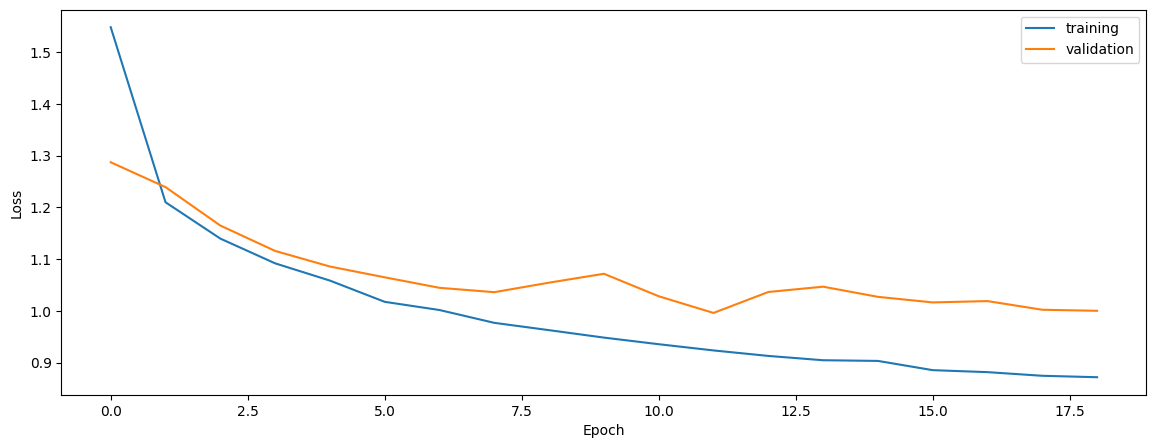

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6354150883007127
0.6181844487619362
0.6294017285262775


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.6545927446954141
0.662677495697074
0.6336874481916147


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6516110694814088
0.6524370117724723
0.6397574379382225


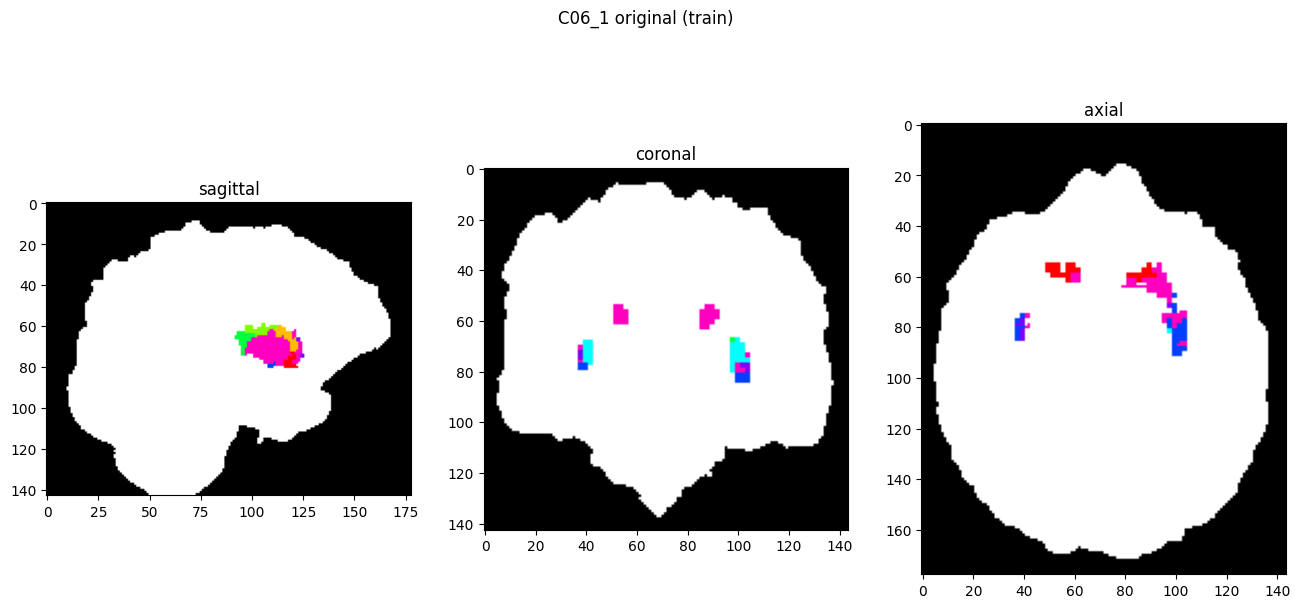

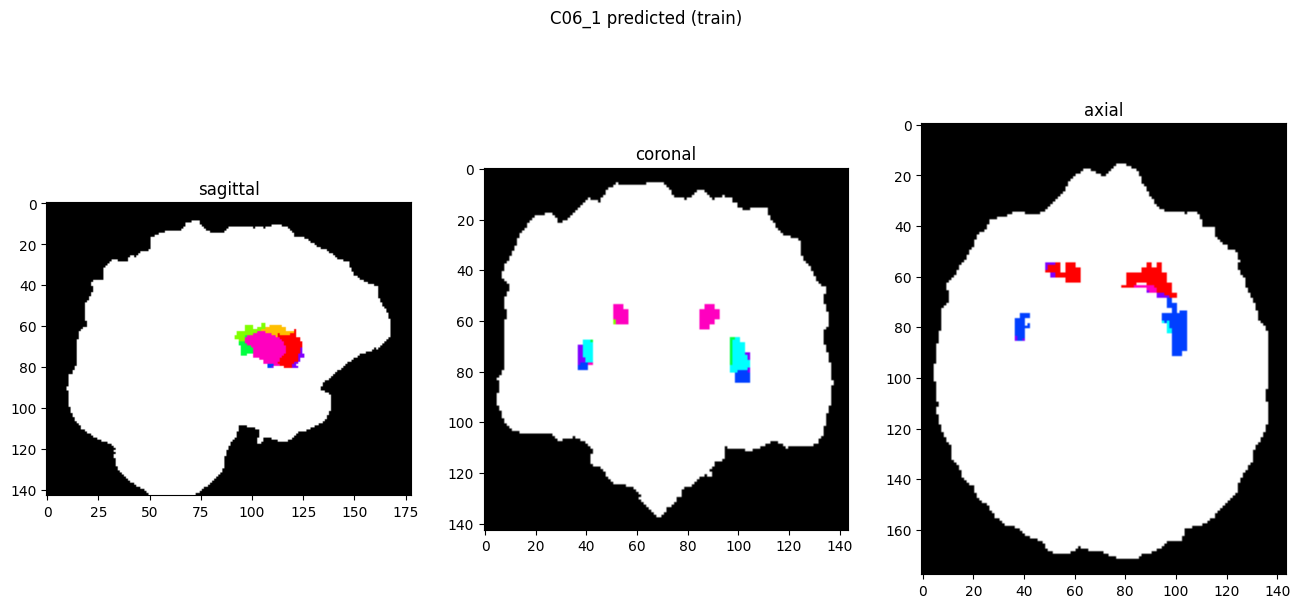

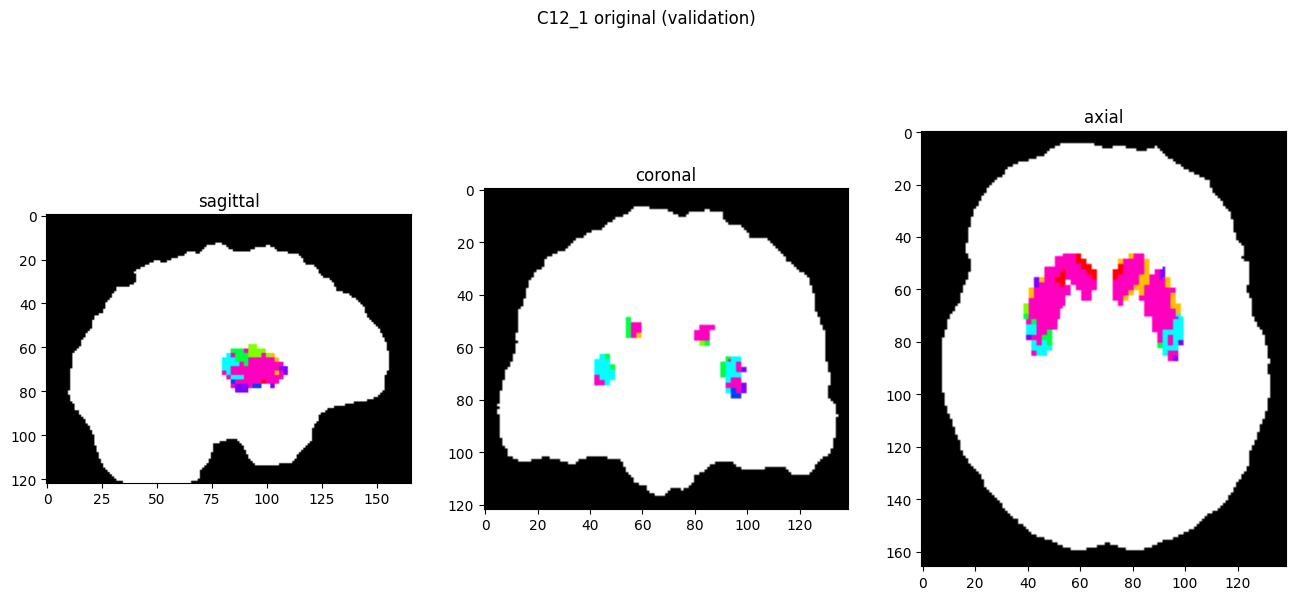

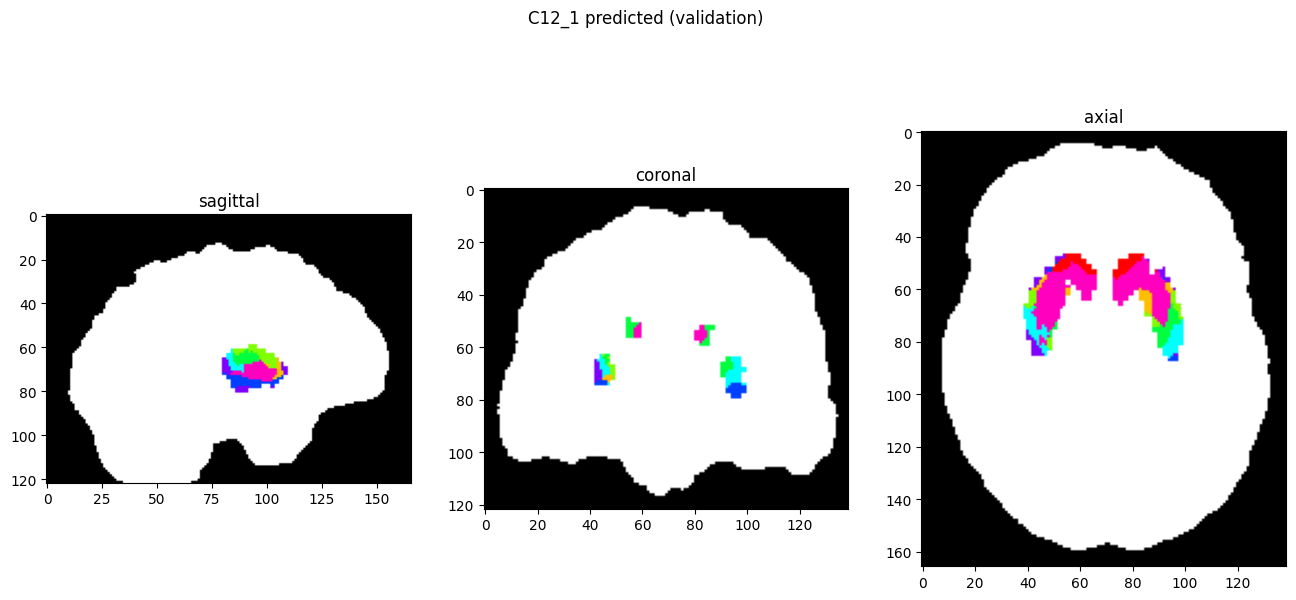

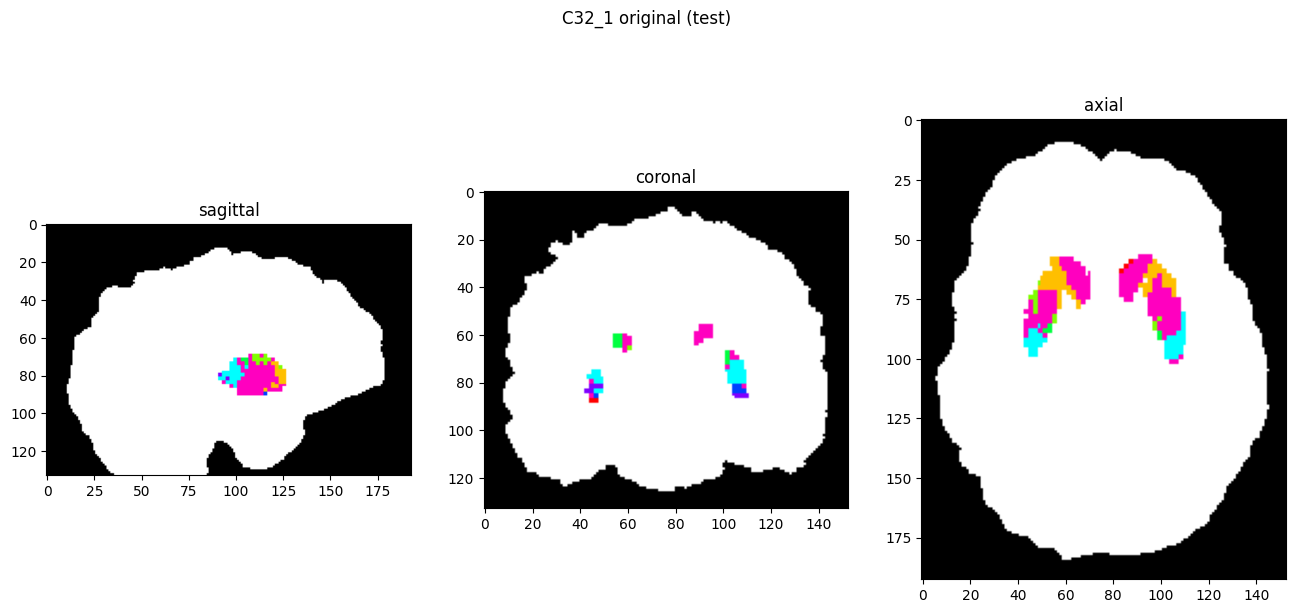

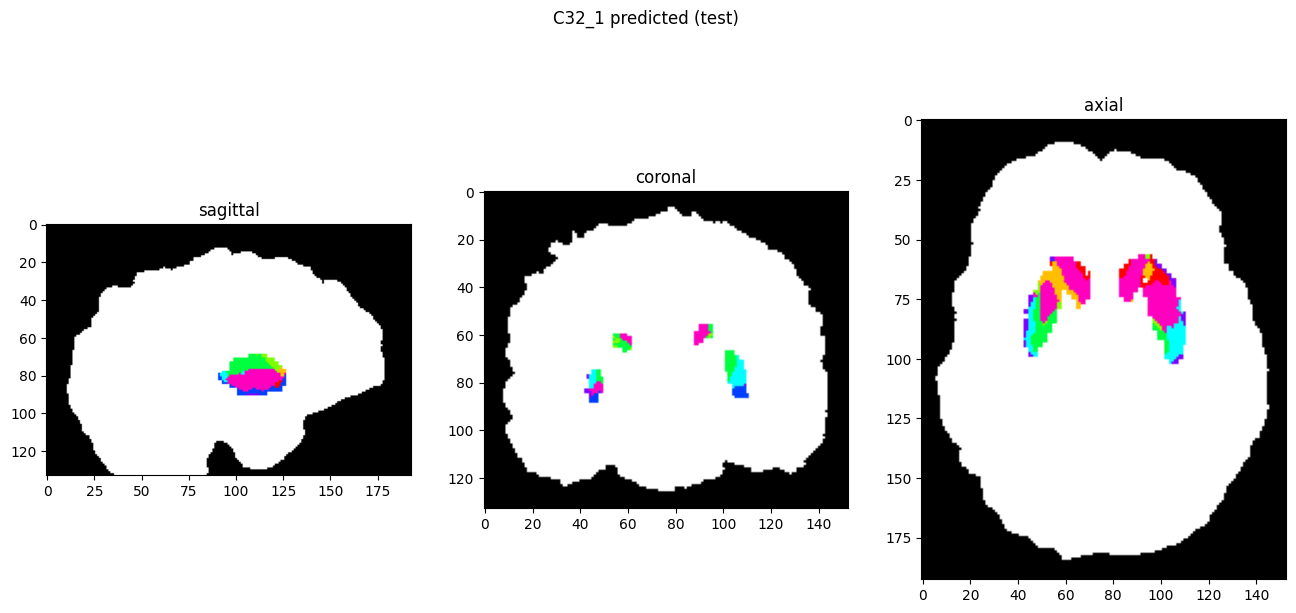

In [10]:
showResults(model, gen, threshold=0)